# Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering,SpectralClustering,AffinityPropagation
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA,FastICA,TruncatedSVD
from sklearn.metrics import silhouette_score
from dython.nominal import associations 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_selection import VarianceThreshold
import datetime as dt
from datetime import date
import math
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [778]:
data=pd.read_excel('online_retail.xlsx')

In [779]:
df=data.copy() #as data is changing so we save a copy of original dataframe
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

# Analyzing for NaN values

In [780]:
for column in data.columns:
    print(f'Column {column} has {(data[column].isnull().sum()*100)/(len(data))}% of NaN values')

Column InvoiceNo has 0.0% of NaN values
Column StockCode has 0.0% of NaN values
Column Description has 0.2683107311375157% of NaN values
Column Quantity has 0.0% of NaN values
Column InvoiceDate has 0.0% of NaN values
Column UnitPrice has 0.0% of NaN values
Column CustomerID has 24.926694334288598% of NaN values
Column Country has 0.0% of NaN values


## For Description Column

In [781]:
print(f'Description contains {data.Description.dtypes} type of data')
print(f'Following are the unique values it contain : \n{set(data.Description)}')

Description contains object type of data
Following are the unique values it contain : 
{'STRAWBERRY SHOPPER BAG', nan, 'CHARLIE AND LOLA CHARLOTTE BAG', 'DOLLY GIRL CHILDRENS BOWL', 'PURPLE LAS VEGAS BRACELET ROUND', 'VINTAGE GLASS COFFEE CADDY', 'WHITE STITCHED CUSHION COVER', 'Bank Charges', 'SCOTTIE DOG HOT WATER BOTTLE', 'GOLD FISHING GNOME', 'ROMANTIC IMAGES NOTEBOOK SET', 'POTTING SHED TEA MUG', 'APPLE BATH SPONGE', 'WHITE TRAVEL ALARM CLOCK', 'SET/4 BADGES BALLOON GIRL', 'PINK HORSE SOCK PUPPET', 'PAPERWEIGHT HOME SWEET HOME', 'damages/dotcom?', 'GLASS BON BON JAR', 'FLOWER BURST SILVER RING CRYSTAL', 'GREEN SWEETHEART BRACELET', 'FELTCRAFT DOLL EMILY', 'LUSH GREENS RIBBONS', 'CHILDRENS CUTLERY POLKADOT BLUE', 'alan hodge cant mamage this section', '6 GIFT TAGS VINTAGE CHRISTMAS ', "GIANT 50'S CHRISTMAS CRACKER", 'LANDMARK FRAME BAKER STREET ', 'CERAMIC STRAWBERRY DESIGN MUG', 'RED METAL BEACH SPADE ', 'VINTAGE RED TEATIME MUG', '75 GREEN PETIT FOUR CASES', 'Dotcom', 'PINK DIAMA

In [782]:
counter=dict(Counter(data.Description))
counts=list(counter.values())
description=list(counter.keys())

### One option is to replace the nan values or ? with the most frequently pruchased item

In [783]:
counter=Counter(data['Description'])
most_common=counter.most_common(1)
max_freq_element=most_common[0][0]
max_freq=most_common[0][1]

second_most_common=counter.most_common(2)[1]
second_max_freq_element=second_most_common[0]
second_max_freq=second_most_common[1]

In [784]:
print(f'Max frequency element is {max_freq_element} with frequency of {max_freq}')
print(f'Max frequency element is {second_max_freq_element} with frequency of {second_max_freq}')

Max frequency element is WHITE HANGING HEART T-LIGHT HOLDER with frequency of 2369
Max frequency element is REGENCY CAKESTAND 3 TIER with frequency of 2200


### So we observe that max frequency is not very larger than second max frequency and thus replacing NaN by mode may not be that efficient

### So, as we can see the data has 0.2683107311375157% of NaN values, so we drop the NaN values

In [785]:
df.dropna(subset=['Description'],inplace=True)
print(df.shape)

(540455, 8)


## For CustomerID

<Axes: xlabel='CustomerID', ylabel='count'>

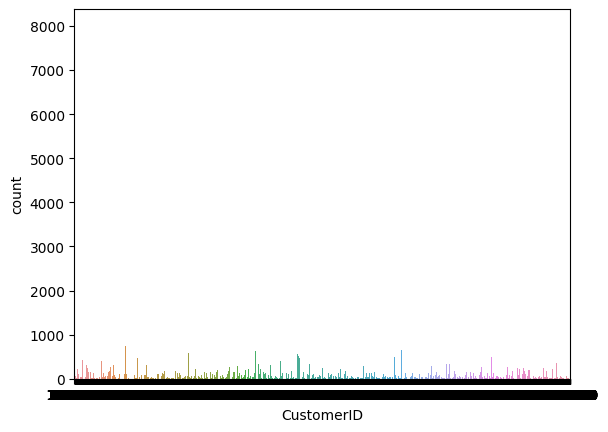

In [786]:
sns.countplot(x='CustomerID',data=df)

### Here clearly we can see that there are 24.92% NaN values in the data column. We can't try replacing with the most frequent value as there are a lot of NaN values so replacing with max would give the max label as most importance

### So, we write Missing in the column of customer whose ID is NaN and add a missing indicator column

In [787]:
transformer=ColumnTransformer(transformers=[
    ('missing_values_indicator', MissingIndicator(),['CustomerID']),
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1),['CustomerID'])
],remainder='passthrough')

In [788]:
non_nan_data=transformer.fit_transform(df)
columns=['missing_values','CustomerID','InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','Country']
non_nan_df=pd.DataFrame(non_nan_data,columns=columns)

### But CustomerID uniquely identifies customer which is our deciding feature in the model so keeping the missing values won't help in analysis.

Text(0.5, 1.0, 'NaN values')

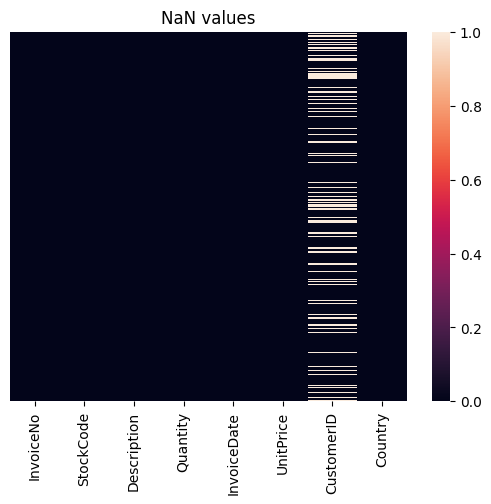

In [789]:
sns.heatmap(df.isnull(),annot=False,yticklabels=False)
plt.title("NaN values")

### So, the NaN values are there at random in customerID so droping them won't affect distribution much too also CustomerID uniquely identifies customer which is our deciding feature in the model so keeping the missing values won't help in analysis. So, we decide to drop the NaN values as that would be the most meaningful in this case

In [790]:
df.dropna(inplace=True)

In [791]:
print(df.head(5))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [792]:
print(df.isnull().sum())
print(len(df))

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
406829


In [793]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [794]:
df['Day']=df['InvoiceDate'].dt.day
df['Month']=df['InvoiceDate'].dt.month
df['Year']=df['InvoiceDate'].dt.year
df['Hour']=df['InvoiceDate'].dt.hour
df['Minute']=df['InvoiceDate'].dt.minute
df['Second']=df['InvoiceDate'].dt.second

In [795]:
df['DayName']=df['InvoiceDate'].dt.day_name()

In [796]:
df.reset_index(drop=True,inplace=True)

In [797]:
new_InvoiceNo=[]
for index in range(len(df['InvoiceNo'])):
    InvoiceNo=df['InvoiceNo'][index]
    if(type(InvoiceNo)==str):
        new_InvoiceNo.append(int(df['InvoiceNo'][index][1:])) #as last 6 digits are numeric
    else:
        new_InvoiceNo.append(InvoiceNo)
del df['InvoiceNo']
df['InvoiceNo']=new_InvoiceNo

In [798]:
df

StockCode                          Description  Quantity  \
0         85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          71053                  WHITE METAL LANTERN         6   
2         84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...                                  ...       ...   
406824     22613          PACK OF 20 SPACEBOY NAPKINS        12   
406825     22899         CHILDREN'S APRON DOLLY GIRL          6   
406826     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
406827     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
406828     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  Day  Month  \
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom    1     12   
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom    1     12   
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom    1     12   
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom    1     12   
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom    1     12   
...                    ...        ...         ...             ...  ...    ...   
406824 2011-12-09 12:50:00       0.85     12680.0          France    9     12   
406825 2011-12-09 12:50:00       2.10     12680.0          France    9     12   
406826 2011-12-09 12:50:00       4.15     12680.0          France    9     12   
406827 2011-12-09 12:50:00       4.15     12680.0          France    9     12   
406828 2011-12-09 12:50:00       4.95     12680.0          France    9     12   

        Year  Hour  Minute  Second    DayName  InvoiceNo  
0       2010     8      26       0  Wednesday     536365  
1       2010     8      26       0  Wednesday     536365  
2       2010     8      26       0  Wednesday     536365  
3       2010     8      26       0  Wednesday     536365  
4       2010     8      26       0  Wednesday     536365  
...      ...   ...     ...     ...        ...        ...  
406824  2011    12      50       0     Friday     581587  
406825  2011    12      50       0     Friday     581587  
406826  2011    12      50       0     Friday     581587  
406827  2011    12      50       0     Friday     581587  
406828  2011    12      50       0     Friday     581587  

[406829 rows x 15 columns]

# Analyzing which of the columns have a low variance

In [799]:
print(df.columns)
del df['StockCode']

Index(['StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'Day', 'Month', 'Year', 'Hour', 'Minute',
       'Second', 'DayName', 'InvoiceNo'],
      dtype='object')


In [800]:
vt=VarianceThreshold(threshold=0)
columns=[
    'Quantity',
    'UnitPrice',
    'Day',
    'Month',
    'Year',
    'Hour',
    'Minute',
    'Second',
    'InvoiceNo', 
]
vt.fit(df[columns])

VarianceThreshold(threshold=0)

In [801]:
print(list(vt.get_support()))

[True, True, True, True, True, True, True, False, True]


### So, the second column have 0 variance and hence we drop it 

In [802]:
del df['Second']

In [803]:
df

Description  Quantity         InvoiceDate  \
0        WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   
1                       WHITE METAL LANTERN         6 2010-12-01 08:26:00   
2            CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   
3       KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   
4            RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   
...                                     ...       ...                 ...   
406824          PACK OF 20 SPACEBOY NAPKINS        12 2011-12-09 12:50:00   
406825         CHILDREN'S APRON DOLLY GIRL          6 2011-12-09 12:50:00   
406826        CHILDRENS CUTLERY DOLLY GIRL          4 2011-12-09 12:50:00   
406827      CHILDRENS CUTLERY CIRCUS PARADE         4 2011-12-09 12:50:00   
406828        BAKING SET 9 PIECE RETROSPOT          3 2011-12-09 12:50:00   

        UnitPrice  CustomerID         Country  Day  Month  Year  Hour  Minute  \
0            2.55     17850.0  United Kingdom    1     12  2010     8      26   
1            3.39     17850.0  United Kingdom    1     12  2010     8      26   
2            2.75     17850.0  United Kingdom    1     12  2010     8      26   
3            3.39     17850.0  United Kingdom    1     12  2010     8      26   
4            3.39     17850.0  United Kingdom    1     12  2010     8      26   
...           ...         ...             ...  ...    ...   ...   ...     ...   
406824       0.85     12680.0          France    9     12  2011    12      50   
406825       2.10     12680.0          France    9     12  2011    12      50   
406826       4.15     12680.0          France    9     12  2011    12      50   
406827       4.15     12680.0          France    9     12  2011    12      50   
406828       4.95     12680.0          France    9     12  2011    12      50   

          DayName  InvoiceNo  
0       Wednesday     536365  
1       Wednesday     536365  
2       Wednesday     536365  
3       Wednesday     536365  
4       Wednesday     536365  
...           ...        ...  
406824     Friday     581587  
406825     Friday     581587  
406826     Friday     581587  
406827     Friday     581587  
406828     Friday     581587  

[406829 rows x 13 columns]

# Visualizing the data and performing analysis upon the data

## Firstly, we find out the customers who visit most frequently

In [804]:
def get_top_categories(column_name,top_k):
    '''
    column_name is the column for which we want top top_k number of items
    '''
    counter=dict(Counter(df[column_name]))
    customer=list(counter.keys())
    frequency=list(counter.values())
    pair=[]
    for i in range(len(frequency)):
        pair.append((frequency[i],customer[i]))
    sorted_pair=sorted(pair)[::-1]
    x_axis=[]
    y_axis=[]
    for i in range(top_k):
        x_axis.append(sorted_pair[i][1])
        y_axis.append(sorted_pair[i][0])
    return x_axis,y_axis

In [805]:
def plot_graph(data,x_axis,y_axis,column_name,hue=None):
    figure=plt.figure(figsize=(20,20))
    sns.barplot(data=df,x=x_axis,y=y_axis,hue=hue)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

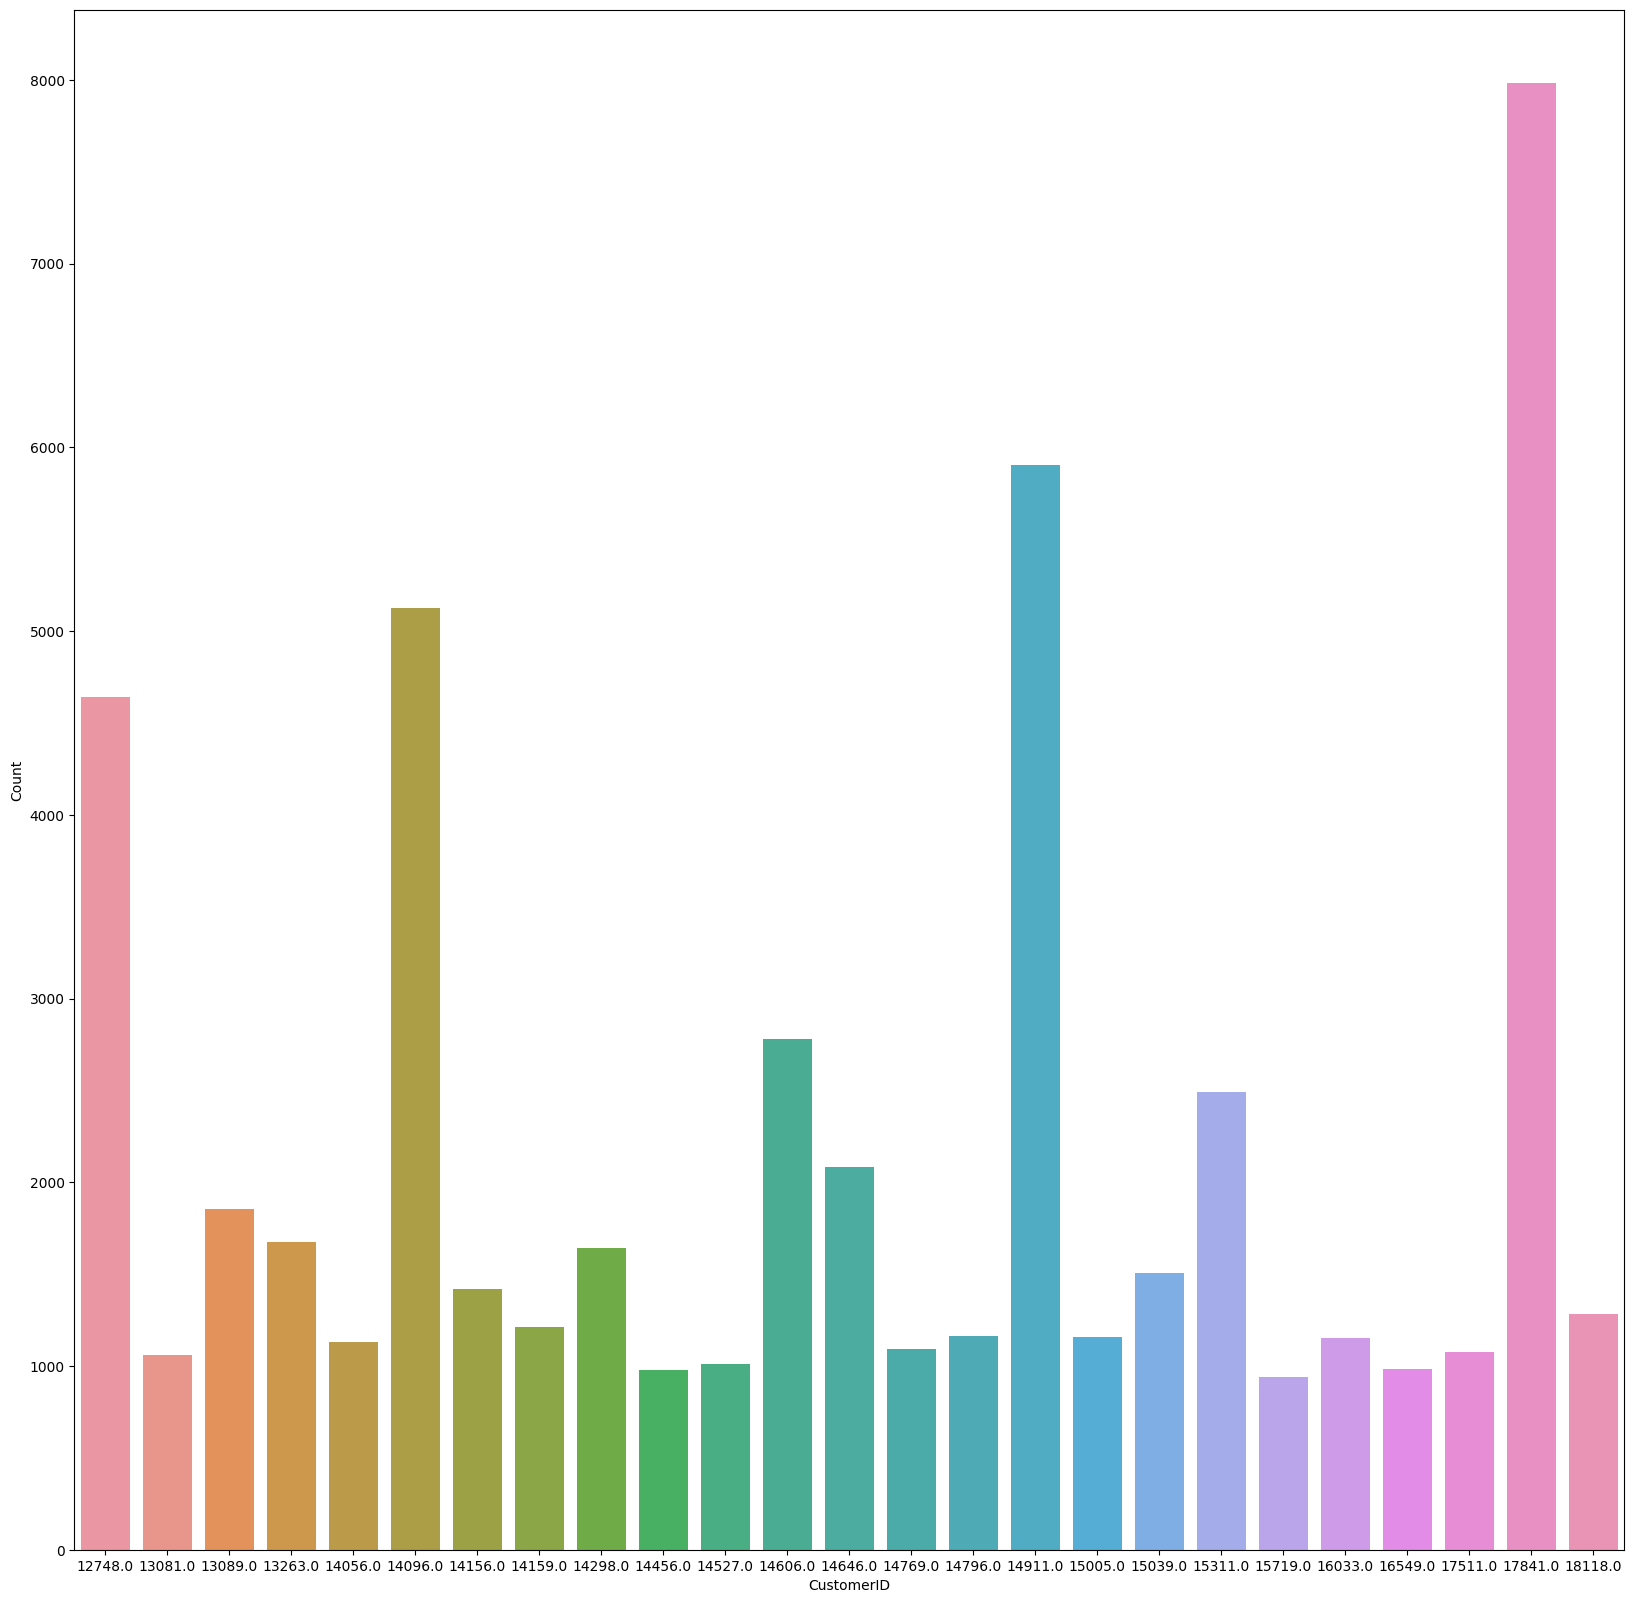

In [806]:
x_axis,y_axis=get_top_categories('CustomerID',25)
plot_graph(df,x_axis,y_axis,'CustomerID')

### So, we can say the customer with customerID as 17841 is the most frequent buyer from this shop

In [807]:
most_frequent_buyer_id=17841.0 #so, we save for the retailer to know about this buyer
second_most_frequent_buyer_id=14911.0
third_most_frequent_buyer_id=14096.0
fourth_most_frequent_buyer_id=12748.0
#we take the 4 most frequent buyers as they buy products way more than other customers as clearly visible

## Now, we analyze which customers spends the maximum amounts in the shop

In [808]:
df['Total Amount']=df['Quantity']*df['UnitPrice']

In [809]:
amount_dict={}
for i in range(len(df)):
    if df['CustomerID'][i] not in amount_dict:
        amount_dict[df['CustomerID'][i]]=df['Total Amount'][i]
    else:
        amount_dict[df['CustomerID'][i]]+=df['Total Amount'][i]

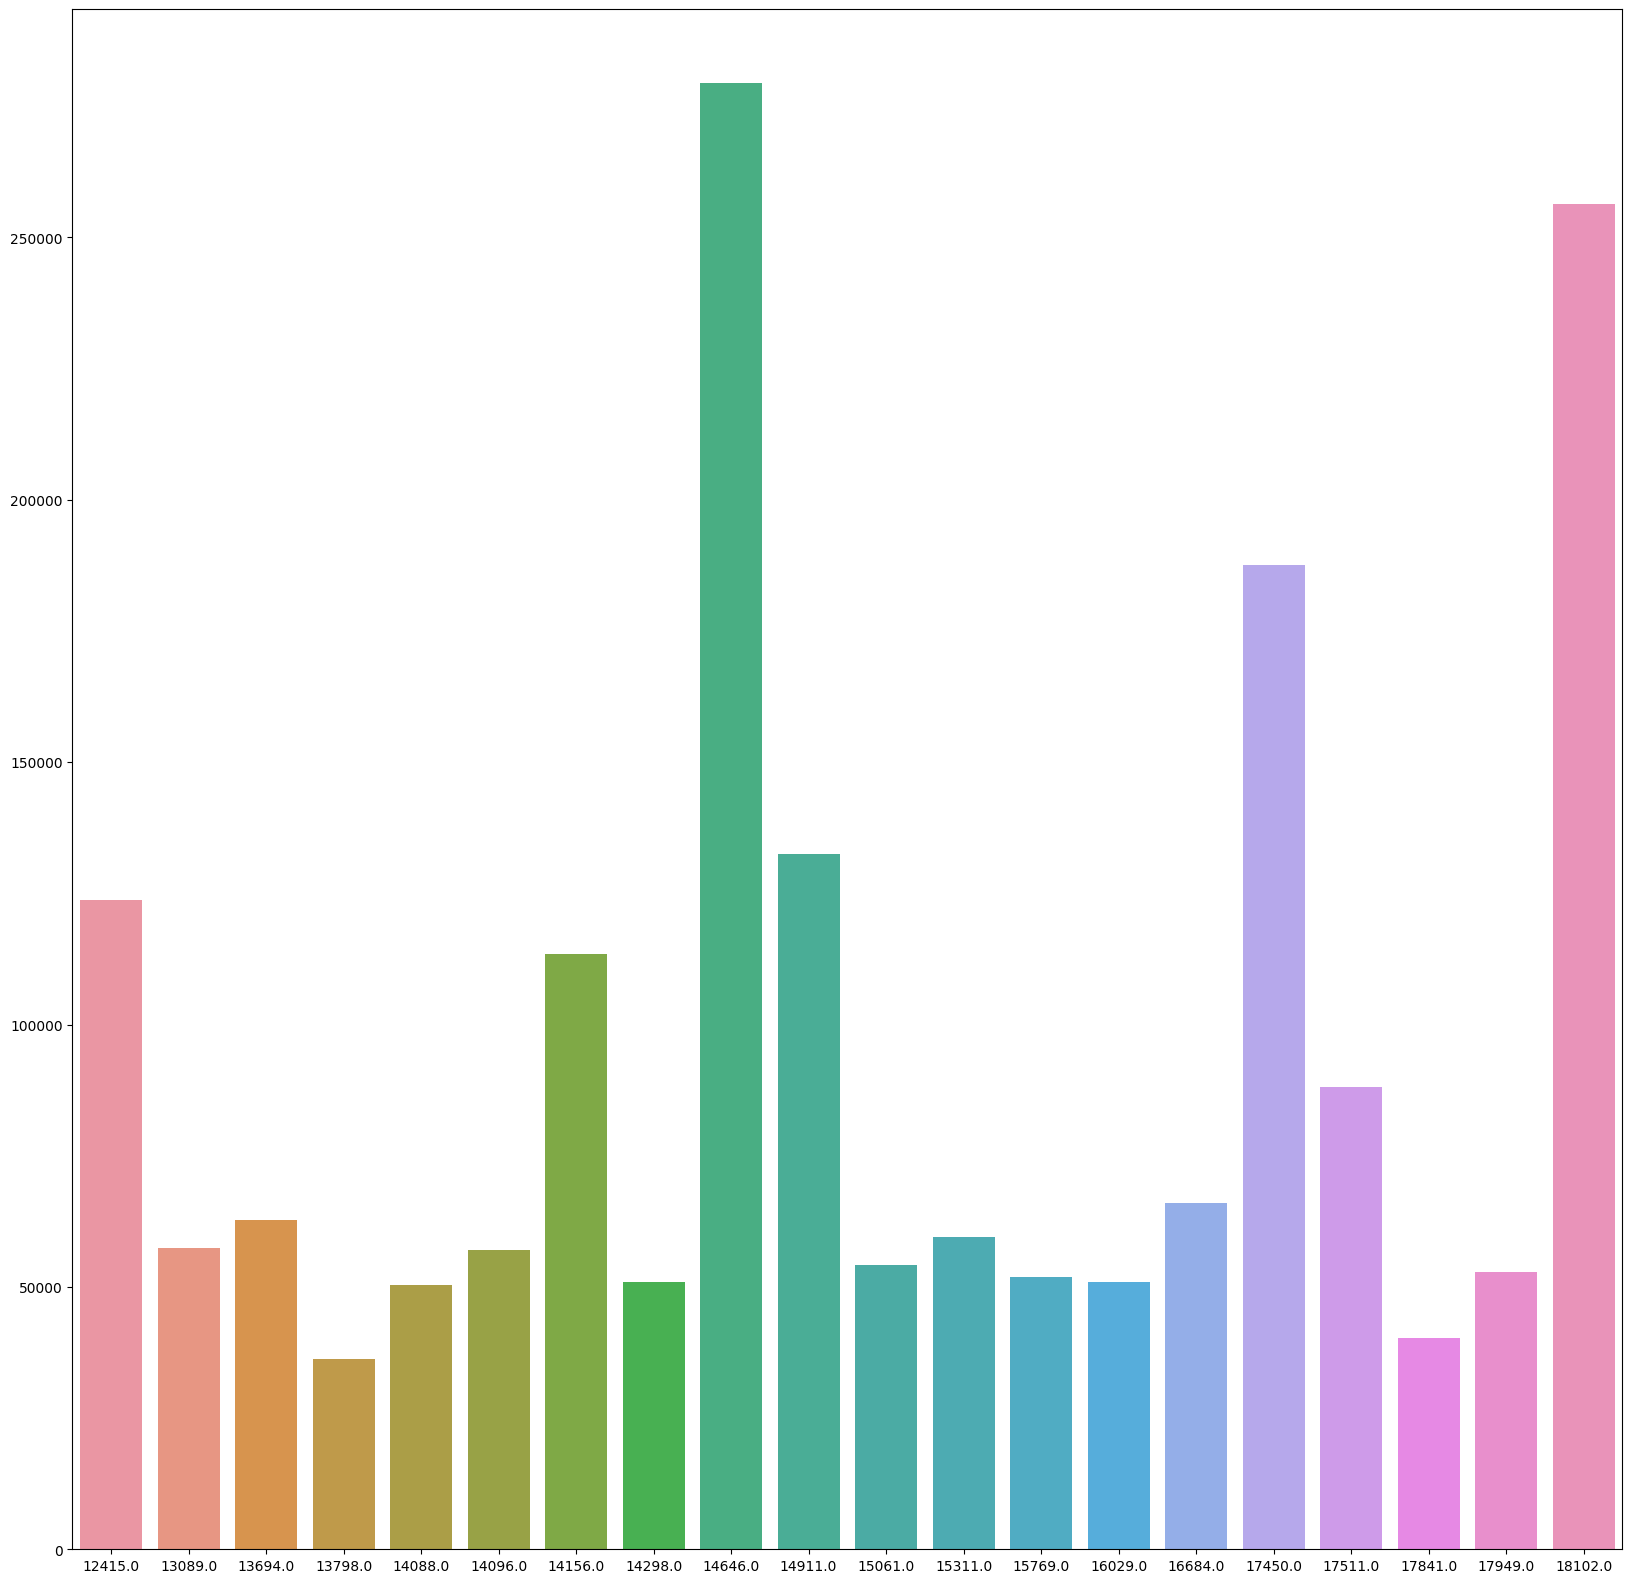

In [810]:
amounts=list(amount_dict.values())
customer_id=list(amount_dict.keys())
pair=[]
for i in range(len(amounts)):
    pair.append((amounts[i],customer_id[i]))
    sorted_pair=sorted(pair)[::-1]
x_axis=[]
y_axis=[]
for i in range(20):
    x_axis.append(sorted_pair[i][1])
    y_axis.append(sorted_pair[i][0])
figure=plt.figure(figsize=(20,20))
sns.barplot(x=x_axis,y=y_axis)
plt.show()

In [811]:
most_amount_spent_id=14646.0
second_most_amount_spent_id=18102.0

In [812]:
#So we add a column for total amount spent by that customer
total_spent=[]
for i in range(len(df)):
    total_spent.append(amount_dict[df['CustomerID'][i]])

In [813]:
df['Total Spent']=total_spent

In [814]:
print(df.head(50))

                            Description  Quantity         InvoiceDate  \
0    WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   
1                   WHITE METAL LANTERN         6 2010-12-01 08:26:00   
2        CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   
3   KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   
4        RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   
5          SET 7 BABUSHKA NESTING BOXES         2 2010-12-01 08:26:00   
6     GLASS STAR FROSTED T-LIGHT HOLDER         6 2010-12-01 08:26:00   
7                HAND WARMER UNION JACK         6 2010-12-01 08:28:00   
8             HAND WARMER RED POLKA DOT         6 2010-12-01 08:28:00   
9         ASSORTED COLOUR BIRD ORNAMENT        32 2010-12-01 08:34:00   
10           POPPY'S PLAYHOUSE BEDROOM          6 2010-12-01 08:34:00   
11            POPPY'S PLAYHOUSE KITCHEN         6 2010-12-01 08:34:00   
12    FELTCRAFT PRINCESS CHARLOTTE DOLL         8 2

## Now, we analyze the sale in different months

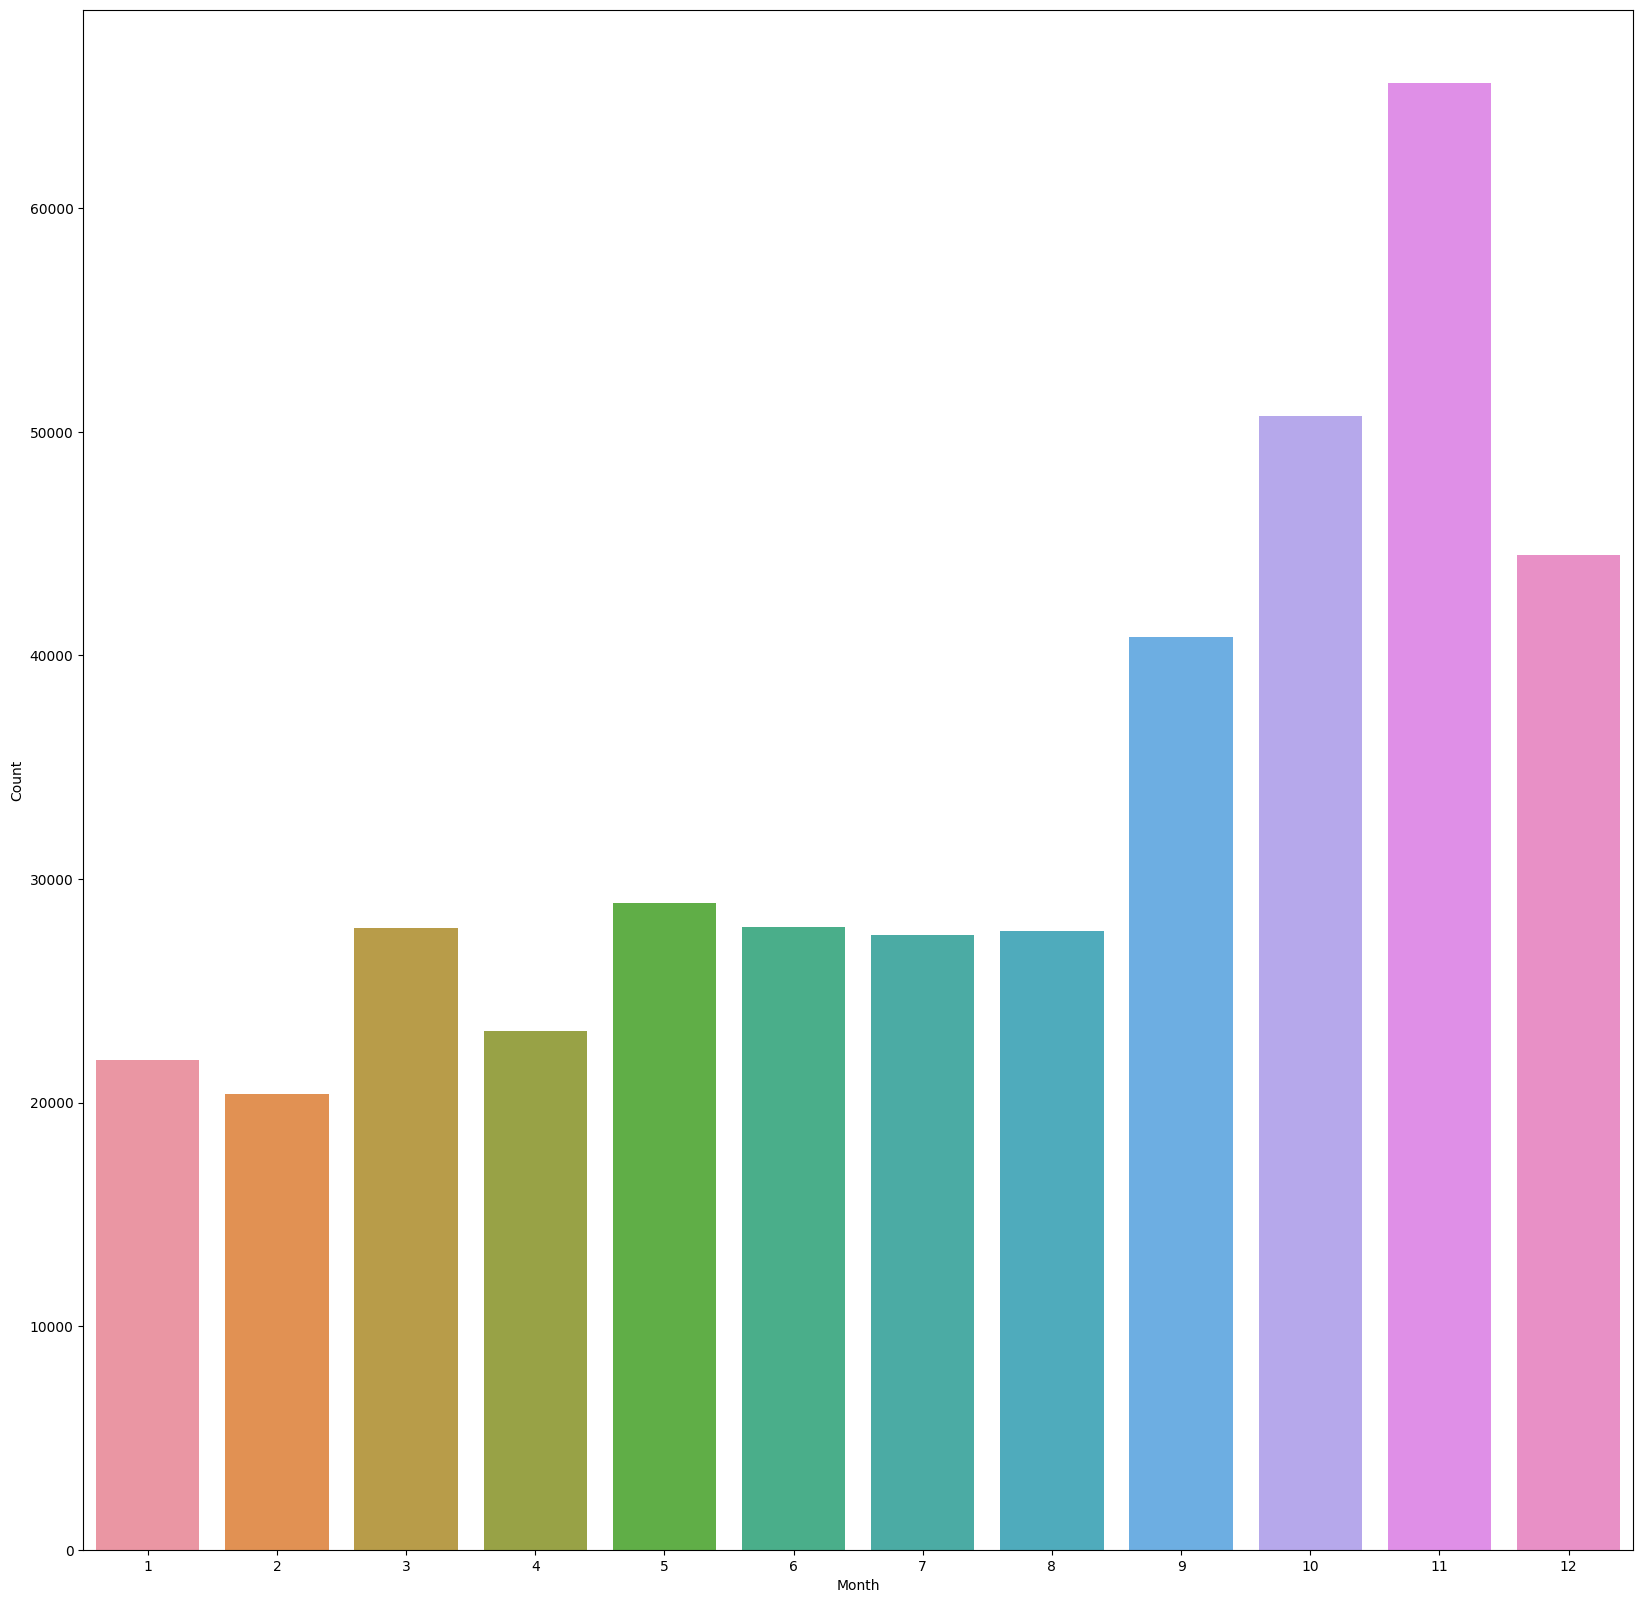

In [815]:
x_axis,y_axis=get_top_categories('Month',12)
plot_graph(df,x_axis,y_axis,'Month')

# So, we can say that November and October had the most sales in the shop

In [816]:
max_selling_month=11
second_max_selling_month=10
third_max_selling_month=12
fourth_max_selling_month=9 #similar reasons as frequent customers

## Now, we also analyze which day has the maximum sale

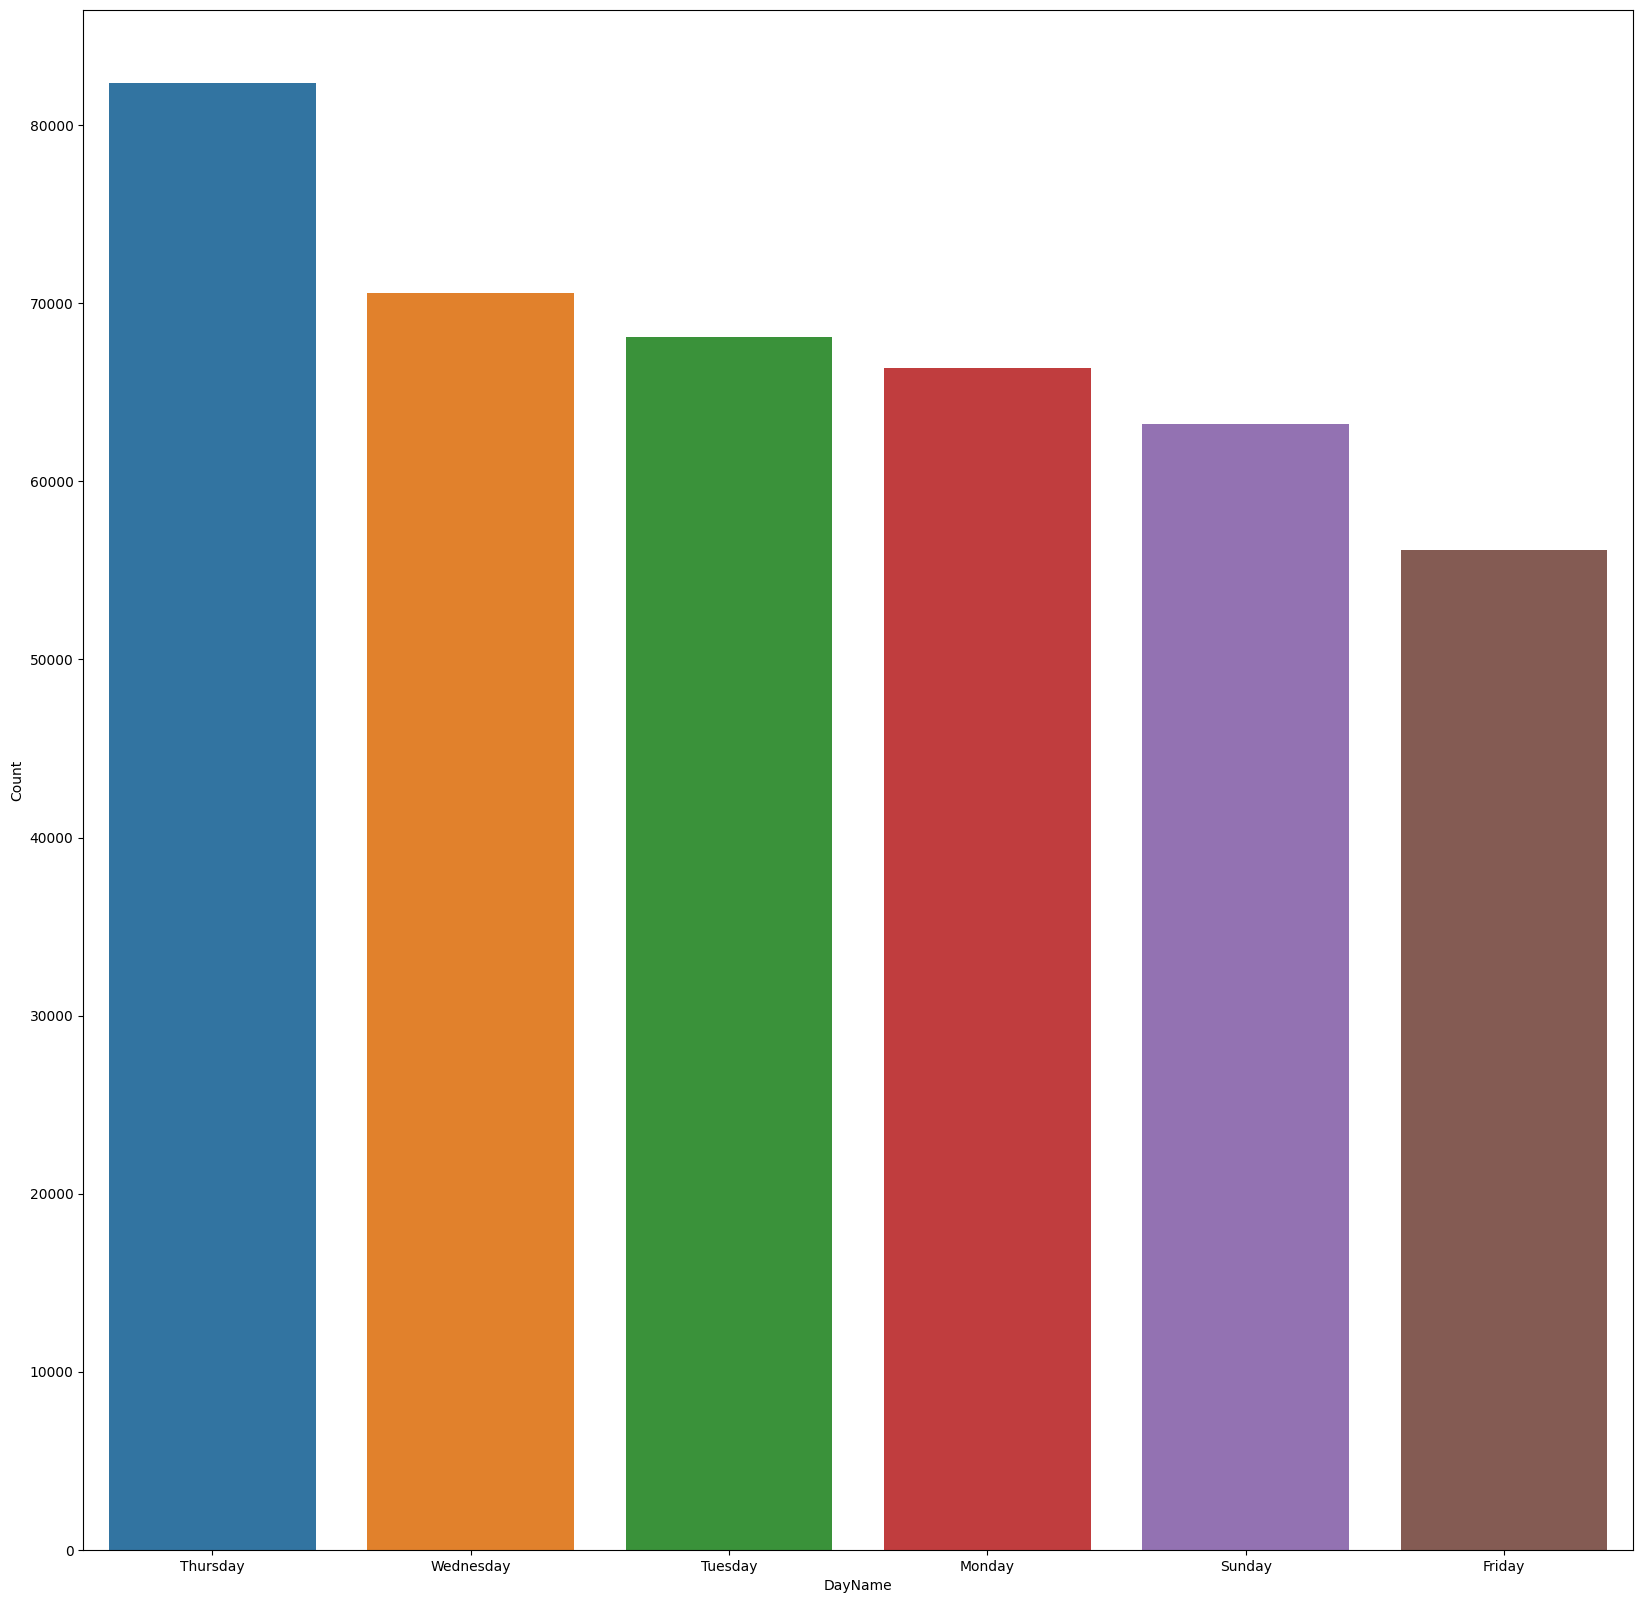

In [817]:
x_axis,y_axis=get_top_categories('DayName',6)
plot_graph(df,x_axis,y_axis,'DayName')

In [818]:
max_sale_day='Thursday' #remaining days sale are approximately similar

## Now, we analyze nearly which hour the sale is the maximum

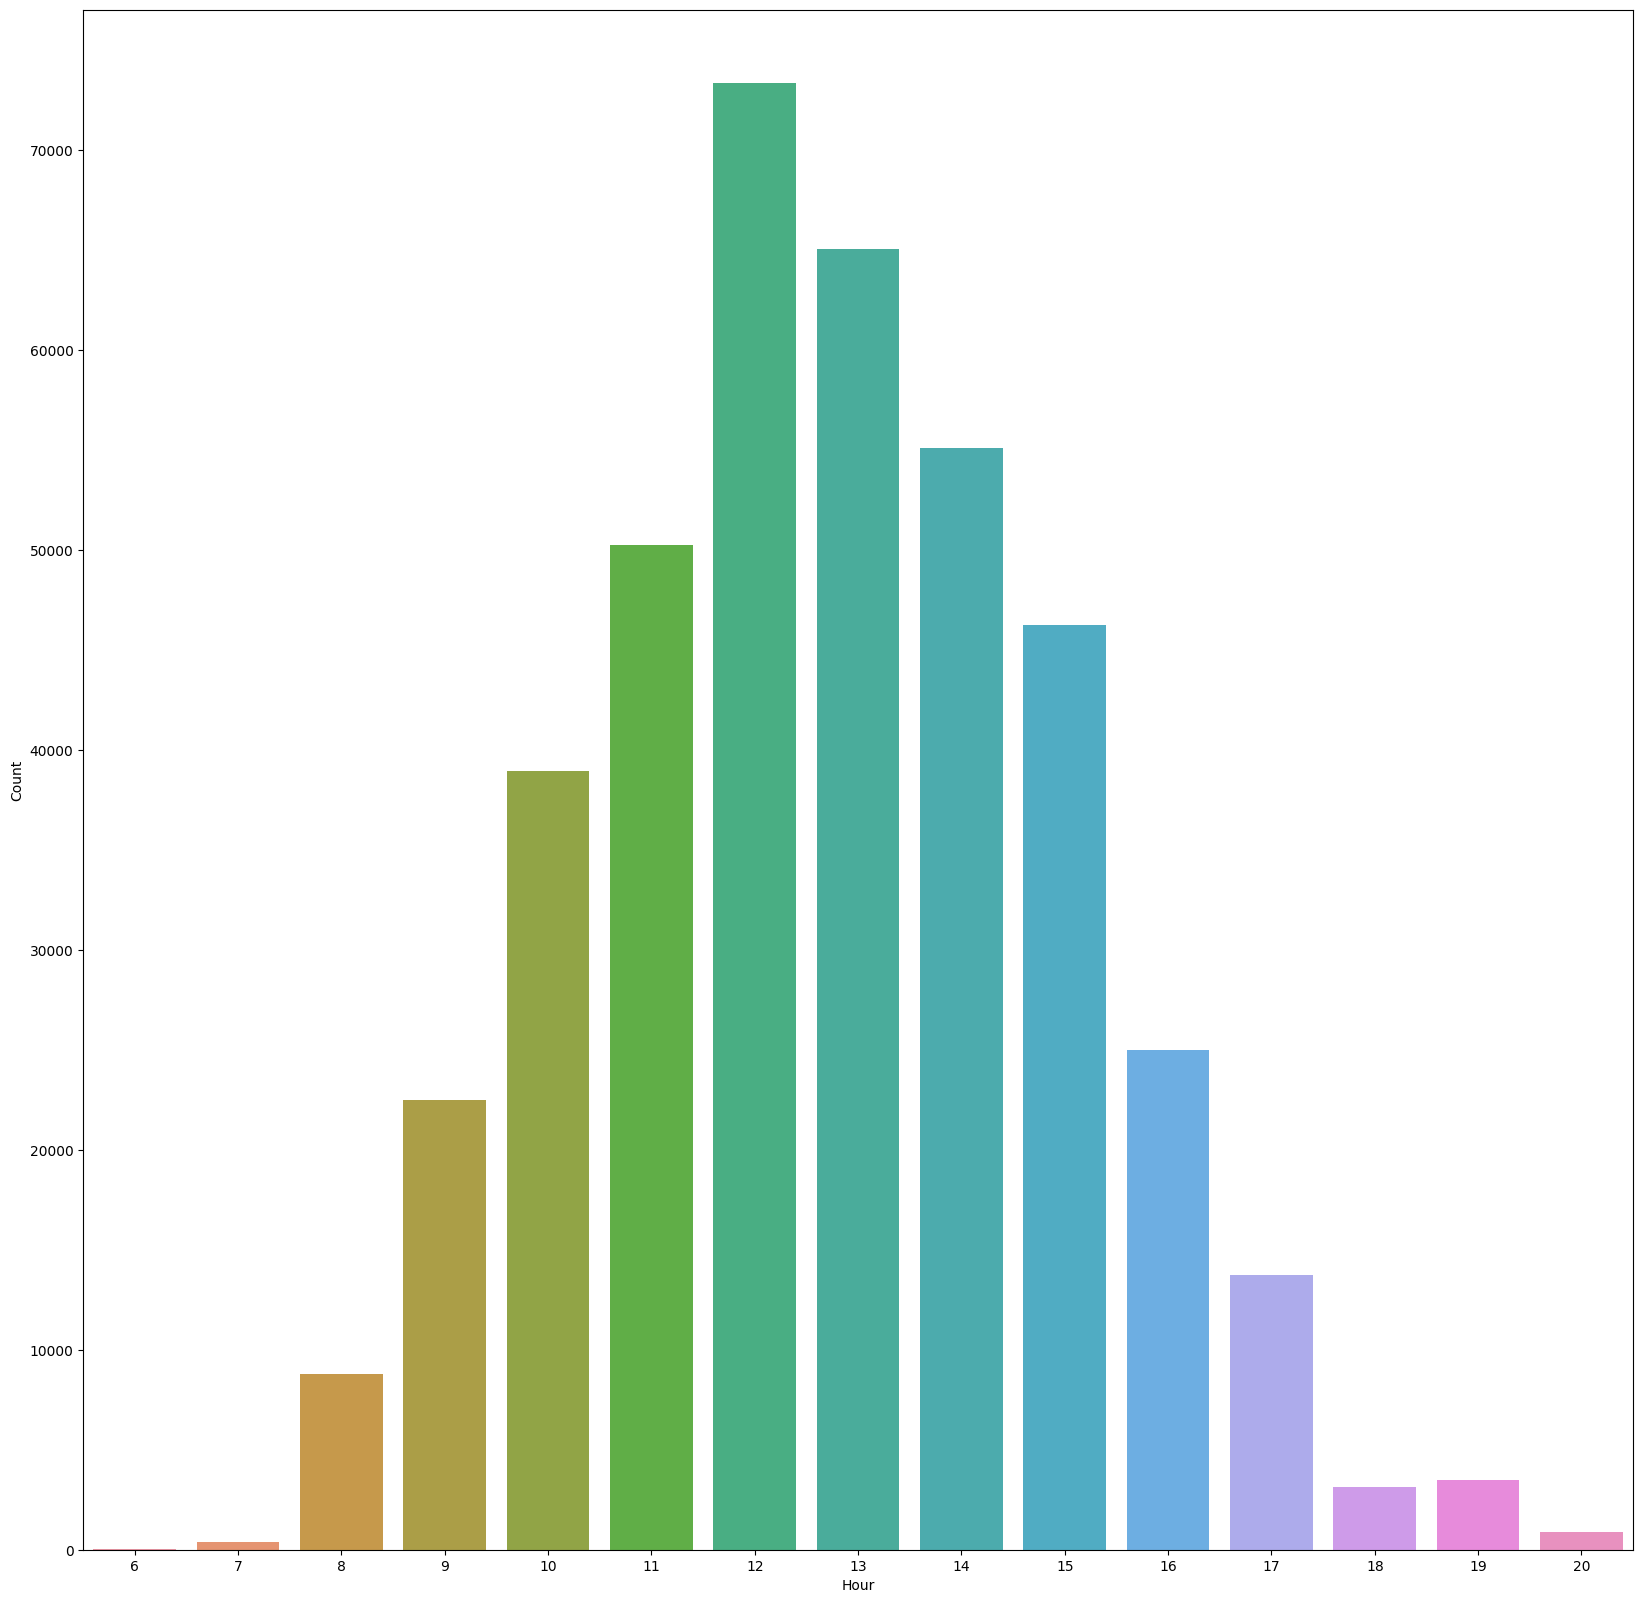

In [819]:
x_axis,y_axis=get_top_categories('Hour',len(Counter(df['Hour'])))
plot_graph(df,x_axis,y_axis,'Hour')

## So peak hours of sale in the shop is between 11 am to 2pm where the retailer needs to be active

## Now, we display the list of top 5 products being sold in the shop

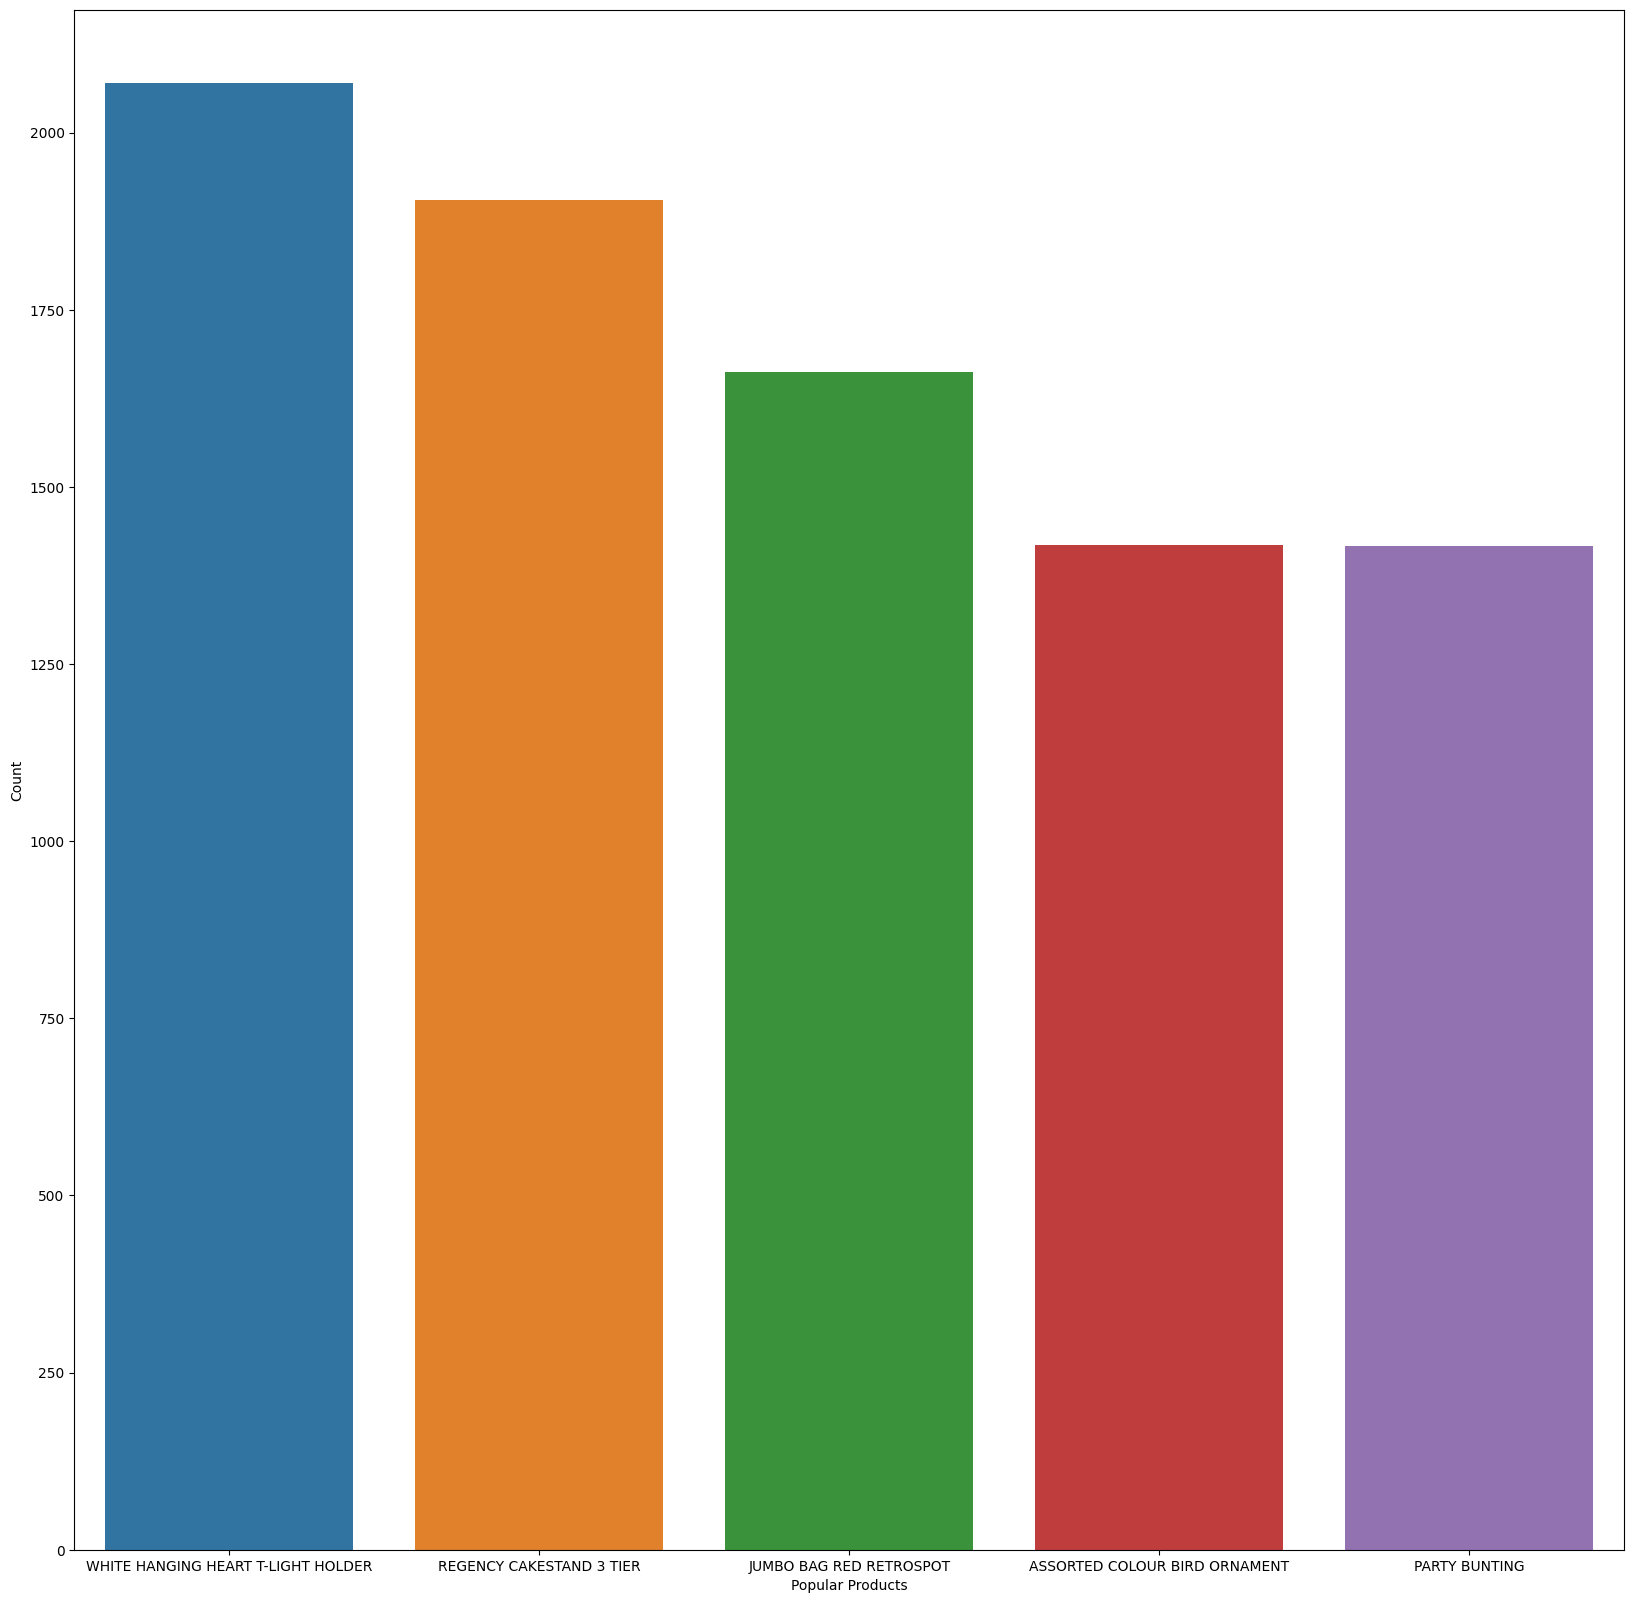

In [820]:
x_axis,y_axis=get_top_categories('Description',5)
figure=plt.figure(figsize=(20,20))
sns.barplot(data=df,x=x_axis,y=y_axis)
plt.xlabel('Popular Products')
plt.ylabel('Count')
plt.show()

In [821]:
best_selling_product=x_axis[0]
second_best_selling_product=x_axis[1]
third_best_selling_product=x_axis[2]


In [822]:
print(best_selling_product)

WHITE HANGING HEART T-LIGHT HOLDER


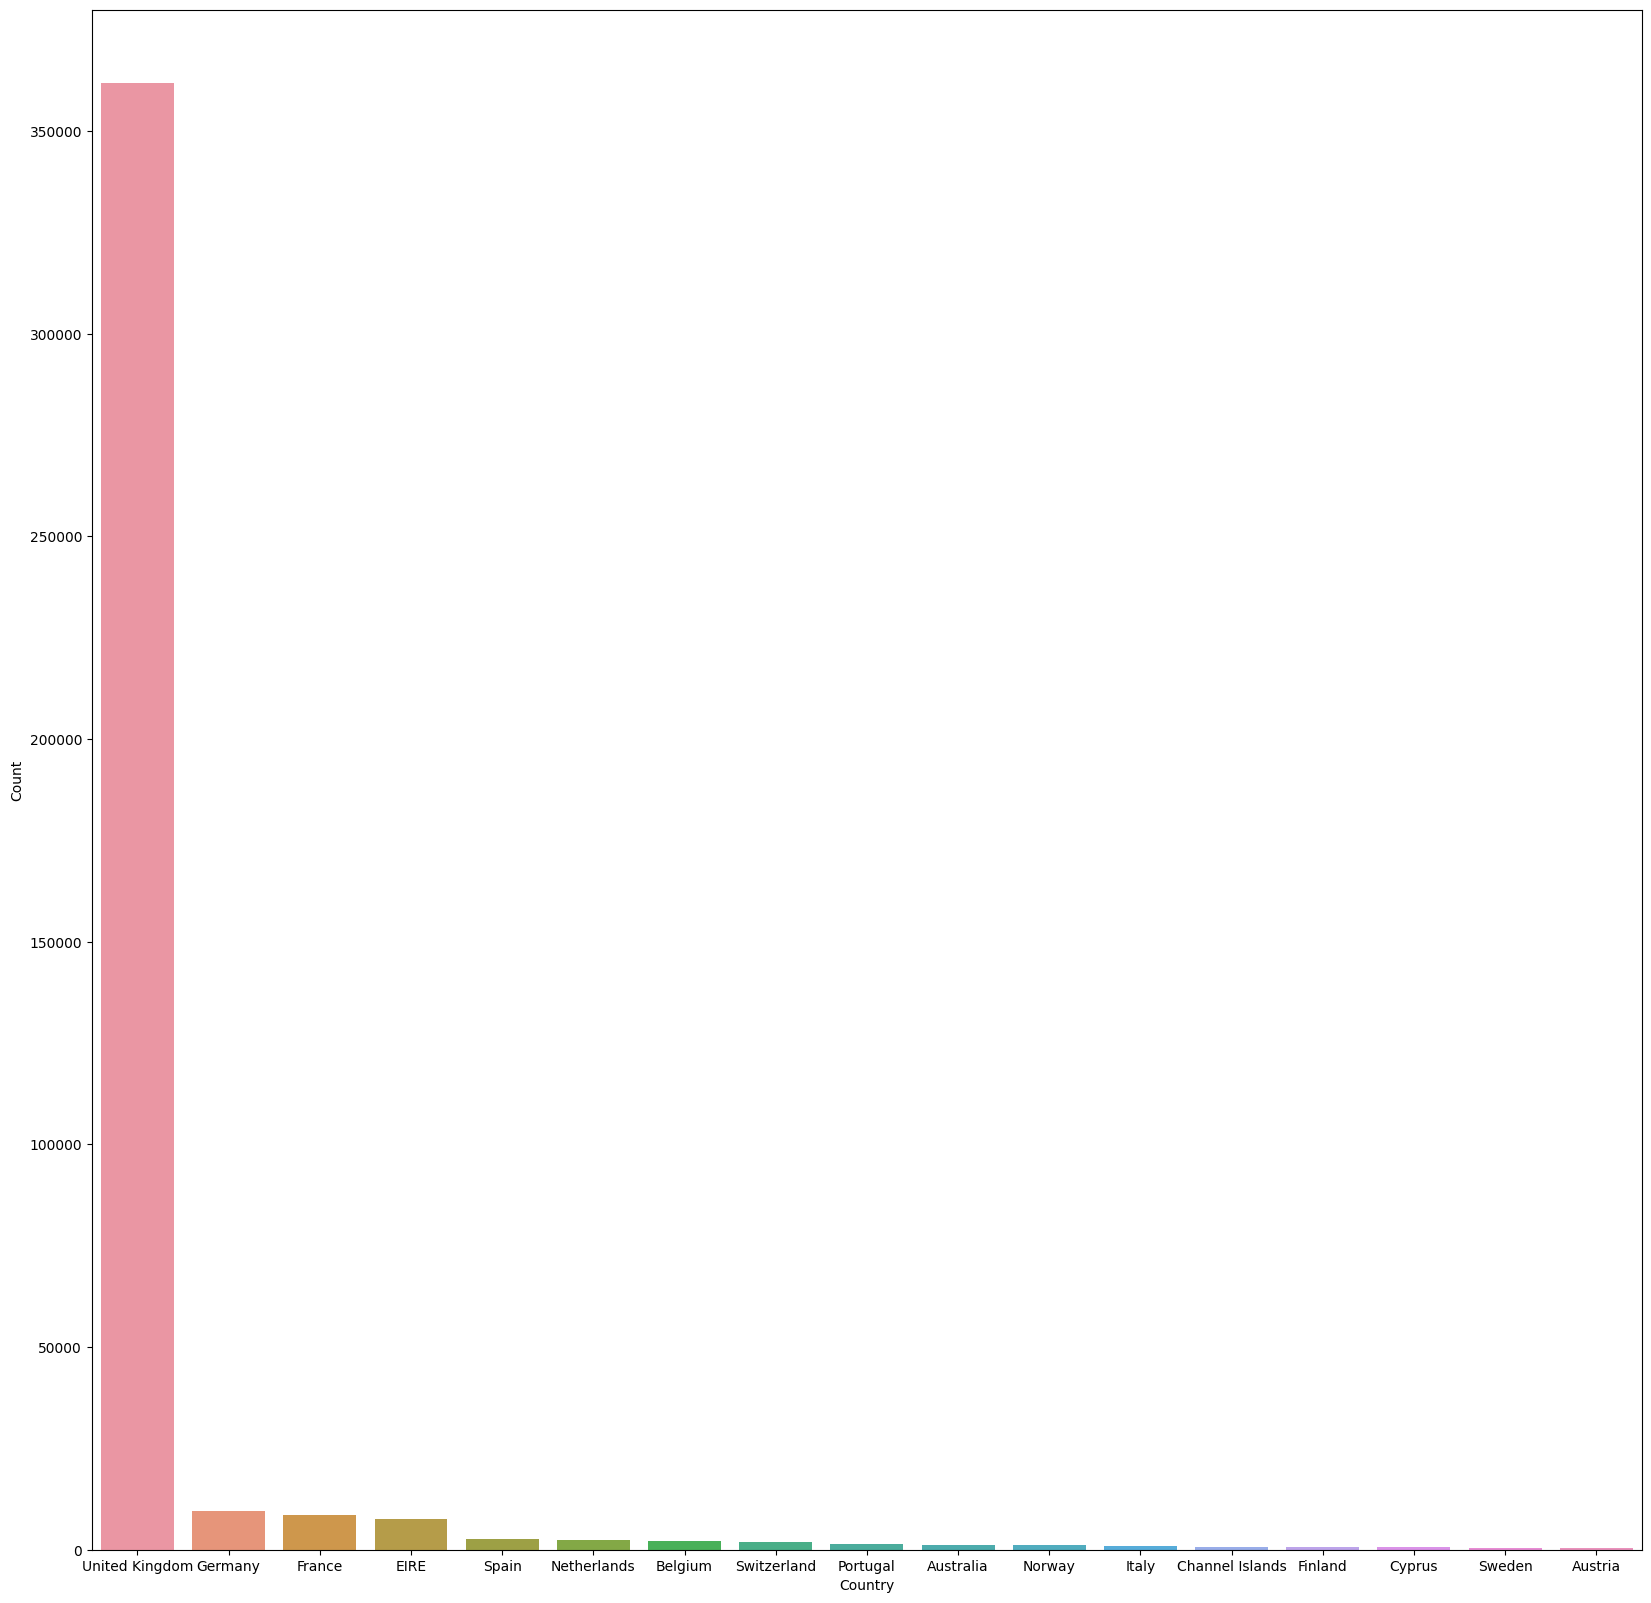

In [823]:
x_axis,y_axis=get_top_categories('Country',len(Counter(df['Country']))-20)
plot_graph(df,x_axis,y_axis,'Country')

## As the shop is located in UK, thus we can see people from other countries are almost negligible so we create another column for foreigner or not

In [824]:
new_country=[]
for i in range(len(df)):
    if(df['Country'][i]=='United Kingdom'):
        new_country.append(1)
    else:
        new_country.append(0)
df['Foreign']=new_country

In [825]:
product_categories={
    'Clothing': 'shirt|t-shirt|top|blouse|sweater|jacket|coat|dress|skirt|pants|jeans|shorts|leggings|underwear|lingerie|socks|stockings',
    'Shoes': 'shoes|boots|sandals|sneakers|heels|flats|slippers',
    'Accessories': 'hat|cap|scarf|gloves|belt|tie|watch|jewelry|bag|purse|wallet',
    'Beauty': 'cosmetics|makeup|skincare|fragrance|haircare|nail polish',
    'Electronics': 'phone|tablet|laptop|desktop|camera|smartwatch|headphones|speaker|chargers|batteries',
    'Home Decor': 'furniture|lighting|bedding|bath|kitchen|decor|art|mirror|candles|plants|curtains|towels',
    'Books': 'book|ebook|audiobook',
    'Sports': 'sports|outdoor|hiking|camping|fitness|exercise|biking|running|yoga|skiing|snowboarding',
    'Toys': 'toy|game|puzzle|board game|card game|doll|action figure|lego',
    'Food': 'food|snack|drink|beverage|coffee|tea|candy|chocolate|sweets',
    'Pet Supplies': 'pet|dog|cat|fish|bird|reptile|hamster|cage|food|toys|treats|litter',
    'Office Supplies': 'office|stationery|paper|pen|pencil|notebook|folder|organizer|printer|ink',
    'Tools': 'tools|hardware|power tool|hand tool|tool box|screwdriver|wrench|drill|saw',
    'Music': 'music|cd|vinyl|instrument|guitar|piano|drum',
    'Movies': 'movie|dvd|blu-ray',
}

In [826]:
def get_product_category(description):
    description=str(description)
    description = description.lower()
    for category, keywords in product_categories.items():
        for keyword in keywords.split('|'):
            if keyword in description:
                return category
    return 'Others'
df['Product Type'] = df['Description'].apply(get_product_category)
del df['Description']

### Feature Construction: We will be using the Recency Frequency Monetary analysis of customer segreagation along with demographic and product type factors

#### For Recency

In [827]:
maximum=max(df['InvoiceDate'])

In [828]:
recent_date=maximum+timedelta(days=1)

In [829]:
Recency=(recent_date-df.groupby('CustomerID')['InvoiceDate'].max())

In [830]:
recency=list(Recency)

In [831]:
rfm_df=pd.DataFrame()
rfm_df['Recency']=recency

In [832]:
rfm_df['Recency_day']=rfm_df['Recency'].dt.days

In [833]:
print(rfm_df)

               Recency  Recency_day
0    326 days 02:33:00          326
1      2 days 20:58:00            2
2     75 days 23:37:00           75
3     19 days 02:59:00           19
4    310 days 20:49:00          310
...                ...          ...
4367 278 days 02:58:00          278
4368 181 days 01:57:00          181
4369   8 days 01:07:00            8
4370   4 days 00:48:00            4
4371  43 days 03:21:00           43

[4372 rows x 2 columns]


#### For Frequency

In [834]:
frequency=df.groupby('CustomerID')['InvoiceNo'].nunique()

#### For Monetary

In [835]:
monetary=df.groupby('CustomerID')['Total Amount'].sum()

## Now we add a column for Country for the customers

In [836]:
RFM_df=pd.DataFrame({'CustomerID':Recency.index,
                    'Frequency':frequency.values,
                    'Monetary':monetary.values})

In [837]:
RFM_df['Recency']=list(rfm_df['Recency_day'])

In [838]:
RFM_df.reset_index(drop=True,inplace=True)

In [839]:
print(RFM_df)

      CustomerID  Frequency  Monetary  Recency
0        12346.0          2      0.00      326
1        12347.0          7   4310.00        2
2        12348.0          4   1797.24       75
3        12349.0          1   1757.55       19
4        12350.0          1    334.40      310
...          ...        ...       ...      ...
4367     18280.0          1    180.60      278
4368     18281.0          1     80.82      181
4369     18282.0          3    176.60        8
4370     18283.0         16   2094.88        4
4371     18287.0          3   1837.28       43

[4372 rows x 4 columns]


## Integrating Product Type(max frequency of type of product customer buys) into our dataset

In [840]:
customer_id_product_map={}
for i in range(len(df)):
    customer_id=df['CustomerID'][i]
    if(customer_id not in customer_id_product_map):
        customer_id_product_map[customer_id]=[df['Product Type'][i]]
    else:
        customer_id_product_map[customer_id].append(df['Product Type'][i])

In [841]:
product_type=[]
for i in range(len(RFM_df)):
    product_type.append(Counter(customer_id_product_map[RFM_df['CustomerID'][i]]).most_common(1)[0][0])
RFM_df['ProductType']=product_type

In [842]:
RFM_df

CustomerID  Frequency  Monetary  Recency  ProductType
0        12346.0          2      0.00      326     Clothing
1        12347.0          7   4310.00        2       Others
2        12348.0          4   1797.24       75       Others
3        12349.0          1   1757.55       19       Others
4        12350.0          1    334.40      310       Others
...          ...        ...       ...      ...          ...
4367     18280.0          1    180.60      278       Others
4368     18281.0          1     80.82      181       Others
4369     18282.0          3    176.60        8       Others
4370     18283.0         16   2094.88        4  Accessories
4371     18287.0          3   1837.28       43       Others

[4372 rows x 5 columns]

## Integrating Country in our dataset

In [843]:
customer_id_country_map={}
for i in range(len(df)):
    customer_id=df['CustomerID'][i]
    if(customer_id not in customer_id_country_map):
        customer_id_country_map[customer_id]=df['Country'][i]

In [844]:
country=[]
for i in range(len(RFM_df)):
    country.append(customer_id_country_map[RFM_df['CustomerID'][i]])
RFM_df['Country']=country

In [845]:
ohe=OneHotEncoder(drop='first')
ohe.fit(RFM_df)
product_type_df=RFM_df.copy()

In [846]:
one_hot_encoded_data = pd.get_dummies(RFM_df,columns=['ProductType'])
print(one_hot_encoded_data)

      CustomerID  Frequency  Monetary  Recency         Country  \
0        12346.0          2      0.00      326  United Kingdom   
1        12347.0          7   4310.00        2         Iceland   
2        12348.0          4   1797.24       75         Finland   
3        12349.0          1   1757.55       19           Italy   
4        12350.0          1    334.40      310          Norway   
...          ...        ...       ...      ...             ...   
4367     18280.0          1    180.60      278  United Kingdom   
4368     18281.0          1     80.82      181  United Kingdom   
4369     18282.0          3    176.60        8  United Kingdom   
4370     18283.0         16   2094.88        4  United Kingdom   
4371     18287.0          3   1837.28       43  United Kingdom   

      ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                           0                  0                     1   
1                           0                  0           

In [847]:
Country=[]
for i in range(len(RFM_df)):
    country=RFM_df['Country'][i]
    if(country=='United Kingdom'):
        Country.append(1)
    else:
        Country.append(0)

In [848]:
one_hot_encoded_data['Country']=Country

In [849]:
df=one_hot_encoded_data

In [850]:
print(df.head(100))

    CustomerID  Frequency  Monetary  Recency  Country  \
0      12346.0          2      0.00      326        1   
1      12347.0          7   4310.00        2        0   
2      12348.0          4   1797.24       75        0   
3      12349.0          1   1757.55       19        0   
4      12350.0          1    334.40      310        0   
..         ...        ...       ...      ...      ...   
95     12462.0          4   1124.01        2        0   
96     12463.0          7   1303.63       46        0   
97     12464.0          8   1212.05       10        0   
98     12465.0          3    733.89        8        0   
99     12468.0          3    724.04      143        0   

    ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                         0                  0                     1   
1                         0                  0                     0   
2                         0                  0                     0   
3                         0

In [851]:
print(df.describe())

         CustomerID    Frequency       Monetary      Recency      Country  \
count   4372.000000  4372.000000    4372.000000  4372.000000  4372.000000   
mean   15299.677722     5.075480    1898.459701    92.047118     0.903477   
std     1722.390705     9.338754    8219.345141   100.765435     0.295341   
min    12346.000000     1.000000   -4287.630000     1.000000     0.000000   
25%    13812.750000     1.000000     293.362500    17.000000     1.000000   
50%    15300.500000     3.000000     648.075000    50.000000     1.000000   
75%    16778.250000     5.000000    1611.725000   143.000000     1.000000   
max    18287.000000   248.000000  279489.020000   374.000000     1.000000   

       ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
count              4372.000000        4372.000000           4372.000000   
mean                  0.053065           0.000457              0.000915   
std                   0.224189           0.021386              0.030237   
min   

# Interpreting the Refunds requested by each Customers

In [852]:
returns=data[data['Quantity']<0]

In [853]:
refund_totals=returns.groupby('CustomerID')['Quantity'].sum()

In [854]:
print(refund_totals)

CustomerID
12346.0   -74215
12352.0      -66
12359.0      -10
12362.0      -17
12365.0       -1
           ...  
18272.0       -6
18274.0      -88
18276.0       -2
18277.0       -1
18282.0       -5
Name: Quantity, Length: 1589, dtype: int64


In [855]:
refunds=[]
for i in range(len(RFM_df)):
    refunds.append(abs(refund_totals.get(RFM_df['CustomerID'][i],0)))

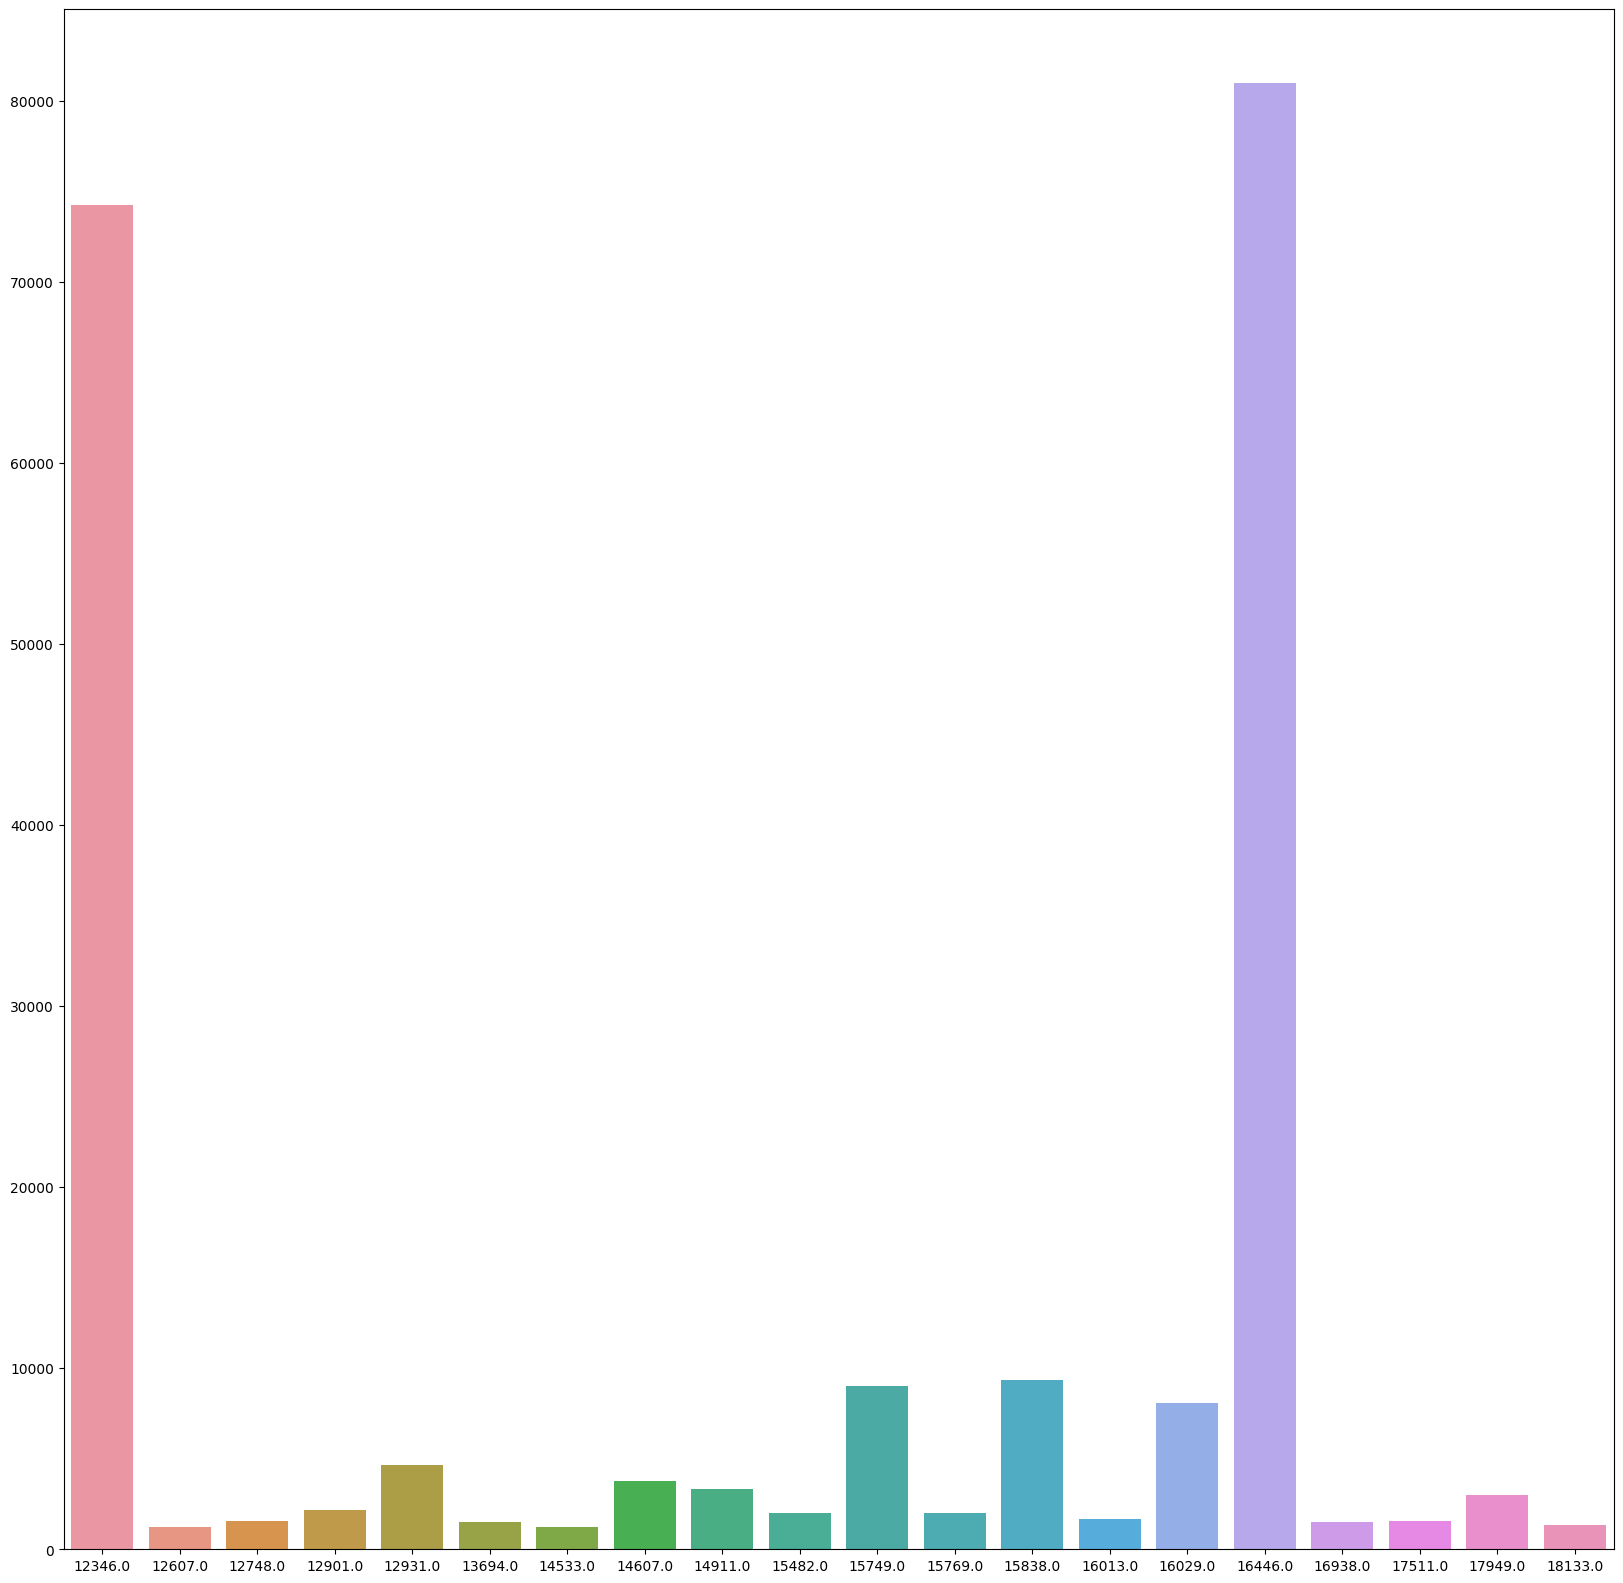

In [856]:
counter=dict(refund_totals)
customer=list(counter.keys())
frequency=list(counter.values())
pair=[]
for i in range(len(frequency)):
    pair.append((abs(frequency[i]),customer[i]))
sorted_pair=sorted(pair)[::-1]
x_axis=[]
y_axis=[]
for i in range(20):
    x_axis.append(sorted_pair[i][1])
    y_axis.append(sorted_pair[i][0])
figure=plt.figure(figsize=(20,20))
sns.barplot(x=x_axis,y=y_axis)
plt.show()

# So, CustomerID 12346.0 and 16446.0 requested for maximum refund amount

## Now, we analyze the columns for non gaussian behaviour using skewness and QQPlot

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


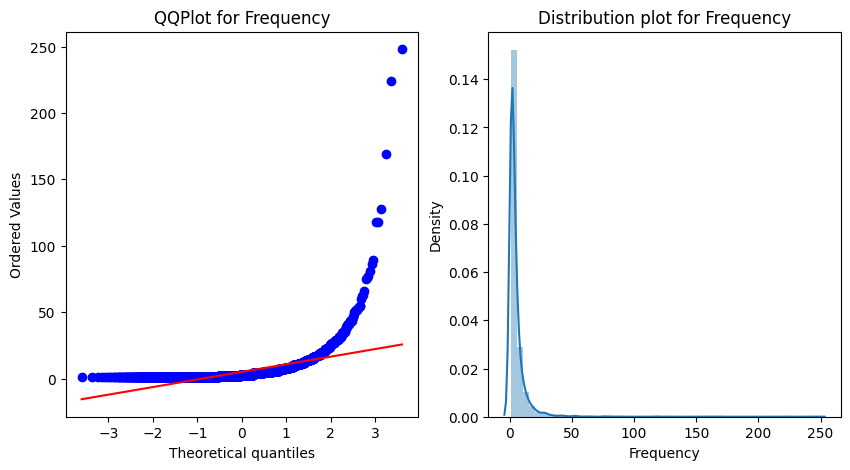

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


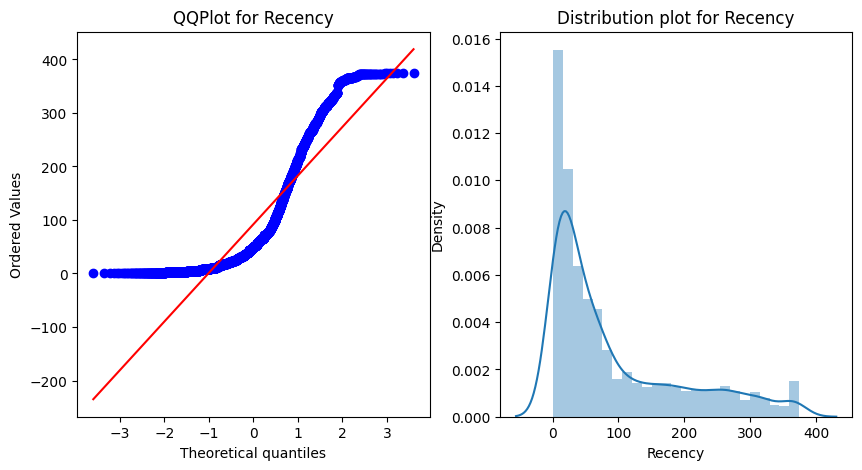

In [857]:
for column in ['Frequency','Recency']:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    stats.probplot(df[column], plot=ax1)
    ax1.set_title(f'QQPlot for {column}')
    sns.distplot(df[column], ax=ax2)
    ax2.set_title(f'Distribution plot for {column}')
    plt.show()

### To remove right skew we use log transform

In [858]:
freq=[]
recen=[]
for i in range(len(df)):
    freq.append(np.log(df['Frequency'][i]))
    recen.append(np.log(df['Recency'][i]))

In [859]:
new_data=df.copy()

In [860]:
new_data['Frequency']=freq
new_data['Recency']=recen

# But that did not make our data gaussian so we leave data as it is

# Now, we apply 4 different clustering algorithms and analyze our data

## We apply standardisation on data first

In [861]:
scaler=StandardScaler()
mean_cust=df['CustomerID'].mean()
mean_freq=df['Frequency'].mean()
mean_money=df['Monetary'].mean()
mean_recen=df['Recency'].mean()
std_cust=df['CustomerID'].std()
std_freq=df['Frequency'].std()
std_money=df['Monetary'].std()
std_recen=df['Recency'].std()
df[['CustomerID','Frequency','Monetary','Recency']]=scaler.fit_transform(df[['CustomerID','Frequency','Monetary','Recency']])

In [862]:
print(df.head(5))

   CustomerID  Frequency  Monetary   Recency  Country  \
0   -1.715067  -0.329362 -0.231001  2.322023        1   
1   -1.714486   0.206102  0.293432 -0.893733        0   
2   -1.713906  -0.115176 -0.012316 -0.169196        0   
3   -1.713325  -0.436455 -0.017146 -0.725005        0   
4   -1.712744  -0.436455 -0.190312  2.163220        0   

   ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                        0                  0                     1   
1                        0                  0                     0   
2                        0                  0                     0   
3                        0                  0                     0   
4                        0                  0                     0   

   ProductType_Electronics  ProductType_Food  ProductType_Home Decor  \
0                        0                 0                       0   
1                        0                 0                       0   
2             

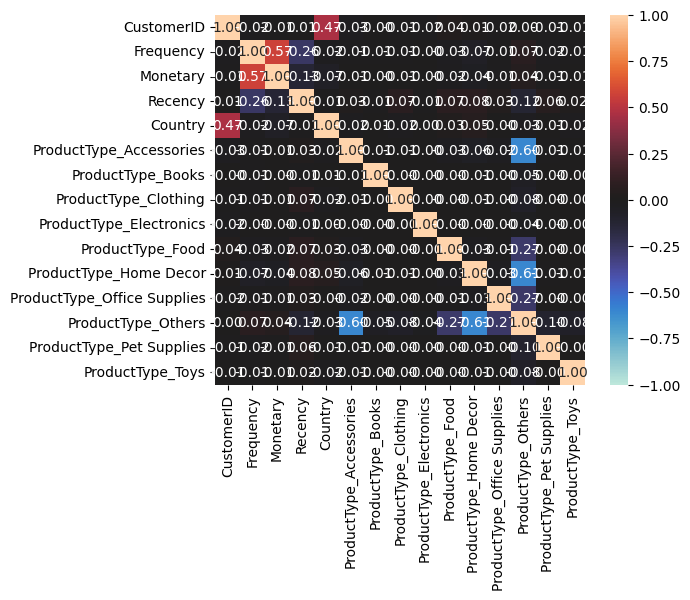

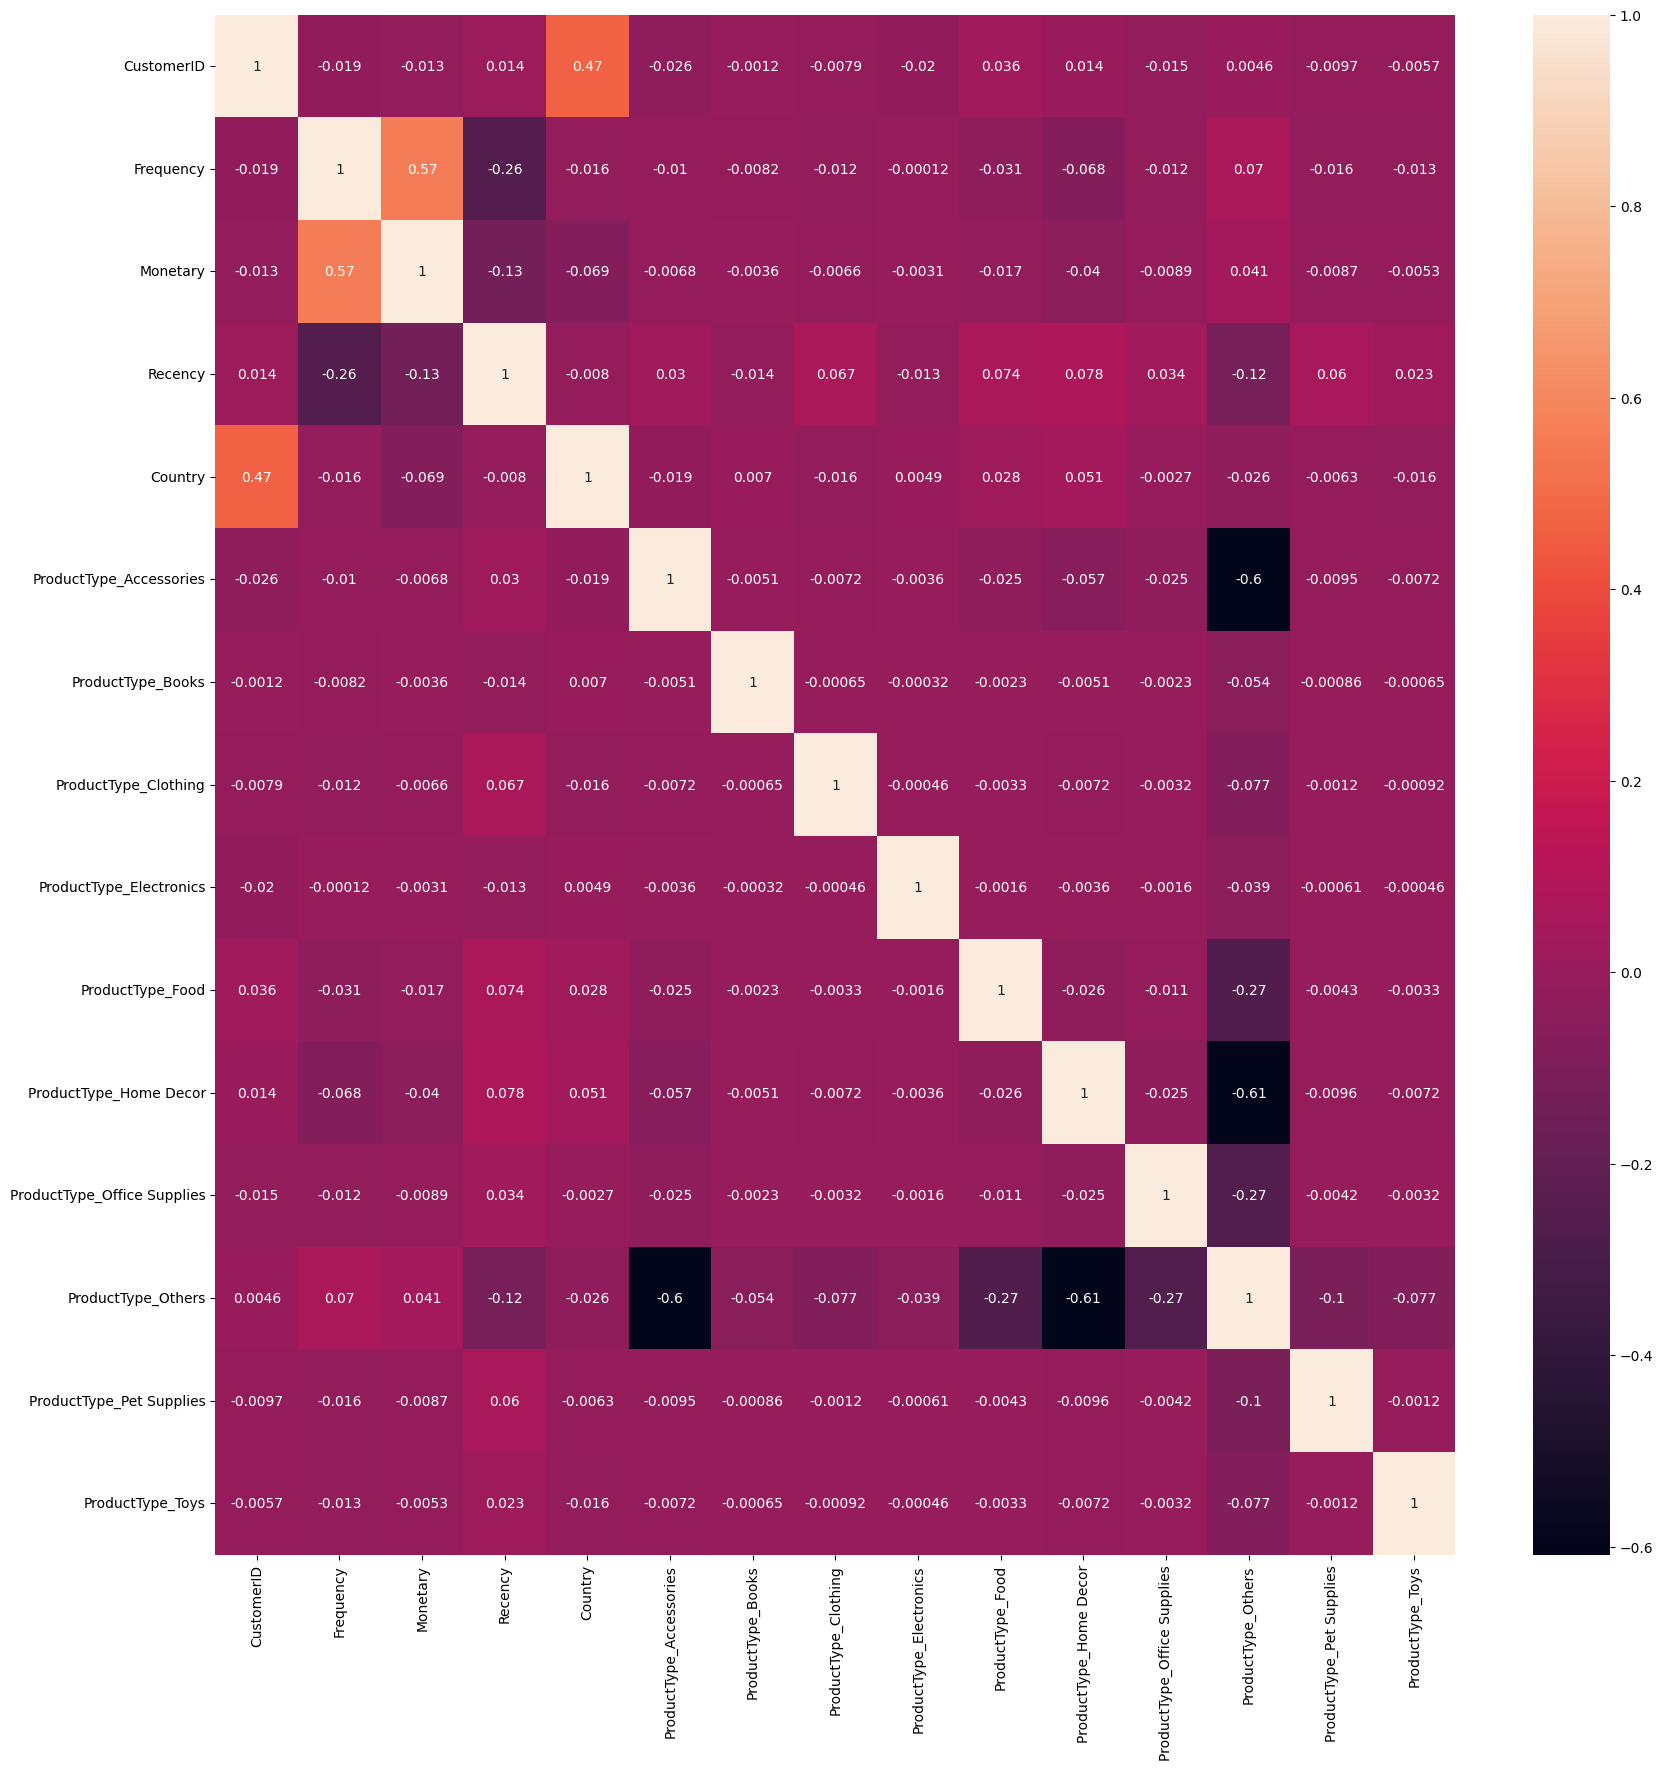

In [863]:
from dython.nominal import associations 
correlations=associations(df)
fig, ax=plt.subplots(figsize=(20, 20))
sns.heatmap(correlations['corr'],annot=True,ax=ax)
plt.show()

### So, none of the features are correlated to each other that much, no need to drop

# DBSCAN

In [864]:
silhouette_score_dictionary={}

## Case 1: Without Feature Extraction

In [865]:
nbrs=NearestNeighbors(n_neighbors=10,algorithm='ball_tree').fit(df)
distances,indices=nbrs.kneighbors(df)
k_distance=distances[:,-1]
k_distance_sorted=np.sort(k_distance)

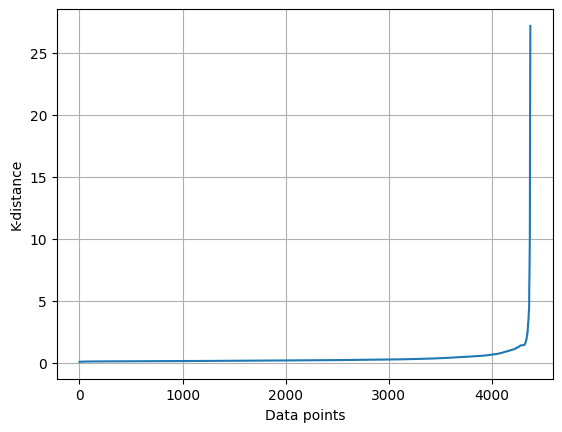

In [866]:
#plotting the k-distance graph to get optimal value of eps
plt.plot(k_distance_sorted)
plt.xlabel('Data points')
plt.ylabel('K-distance')
plt.grid()
plt.show()

#### So eps=1 is approximately the optimal value of eps here

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


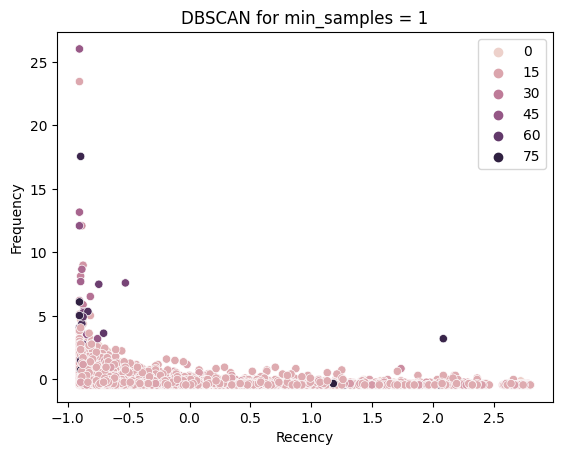

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


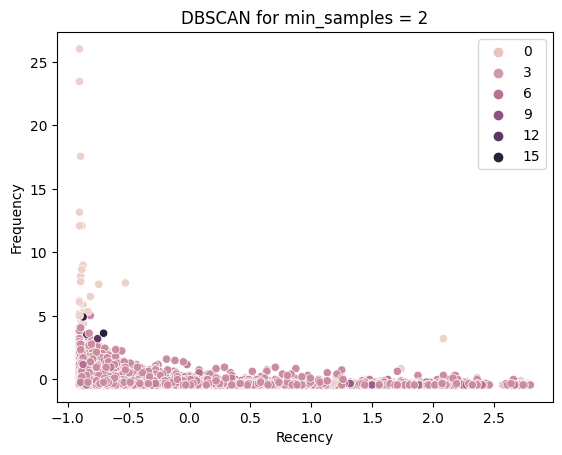

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


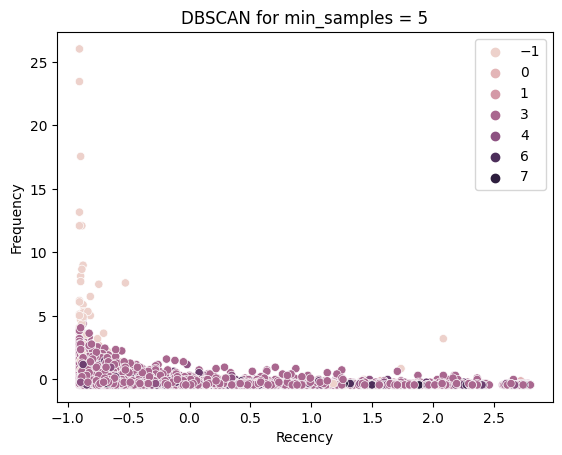

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


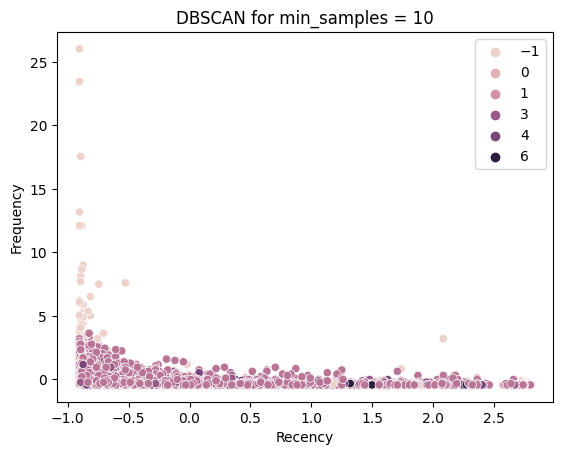

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


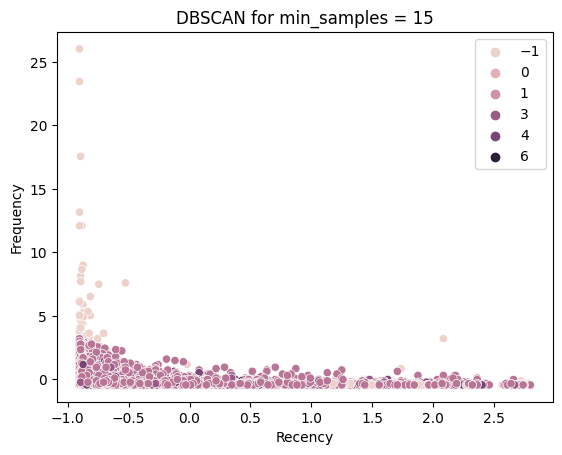

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


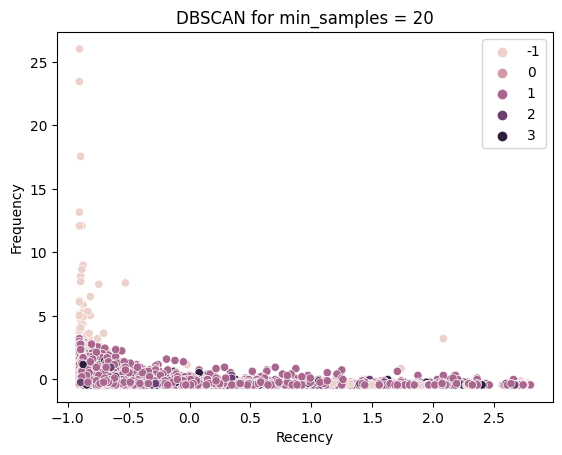

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


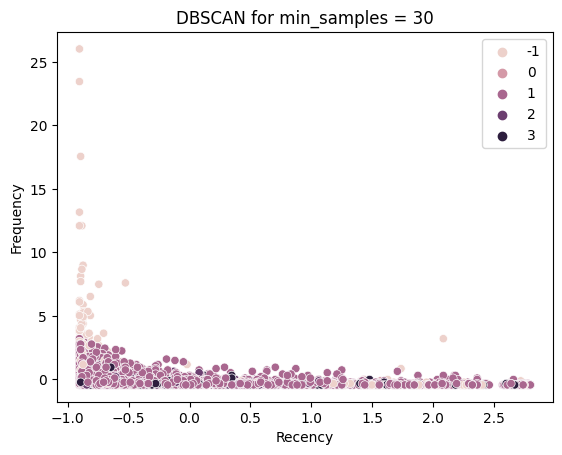

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


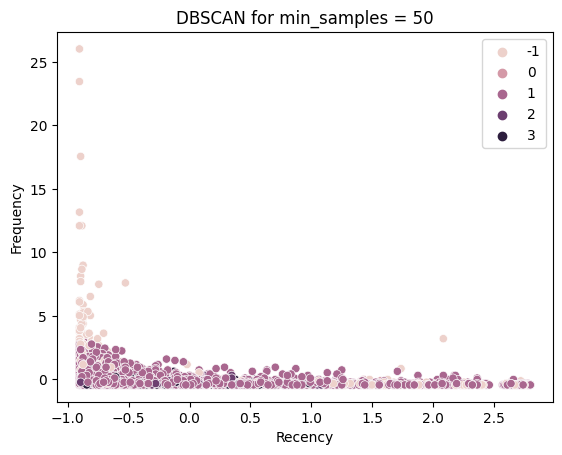

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


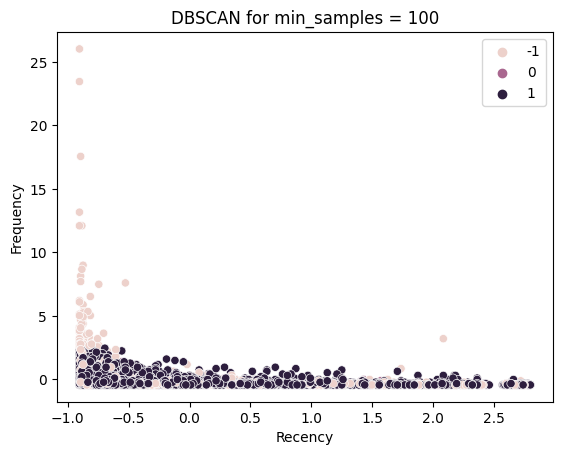

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


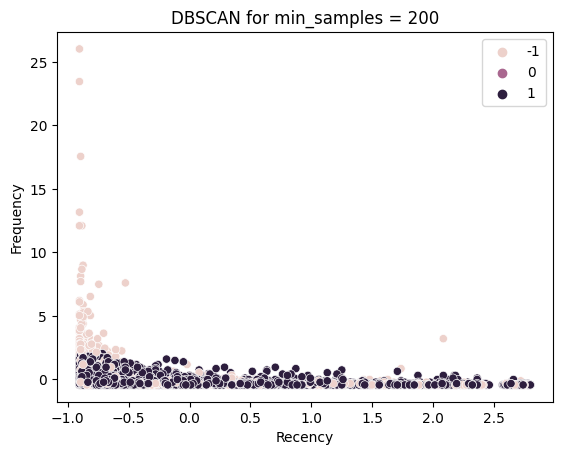

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


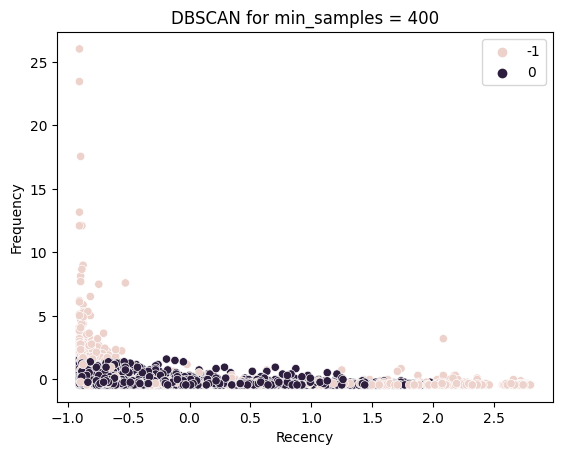

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


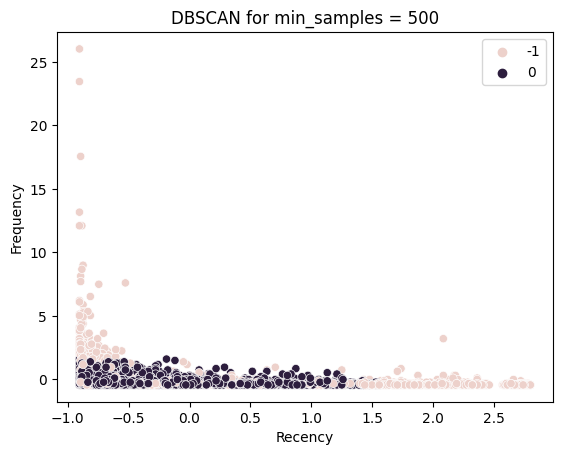

In [867]:
possible_min_samples=[1,2,5,10,15,20,30,50,100,200,400,500]
silhouette_scores=[]
for min_samples in possible_min_samples:
    dbscan1=DBSCAN(eps=1,min_samples=min_samples)
    transformed_df=dbscan1.fit(df)
    labels=dbscan1.labels_
    silhouette_scores.append(silhouette_score(df,labels))
    sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
    plt.title(f'DBSCAN for min_samples = {min_samples}')
    plt.show()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Silhouette Score')

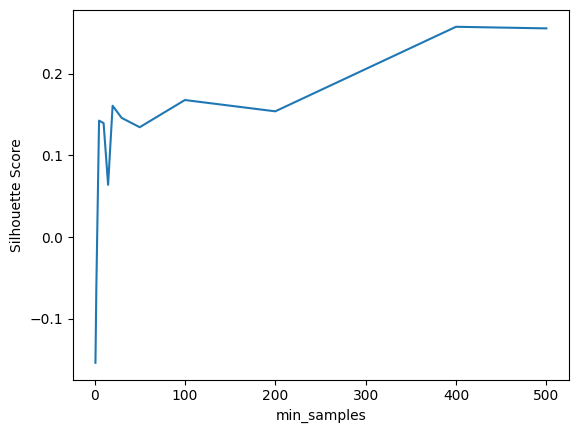

In [868]:
sns.lineplot(possible_min_samples,silhouette_scores)
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')

### So, for min_samples=400 we get the best silhouette score 

In [869]:
dbscan1=DBSCAN(eps=1,min_samples=400)
dbscan1.fit(df)
labels=dbscan1.labels_
silhouette_score_dictionary['DBSCAN']=max(silhouette_scores)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

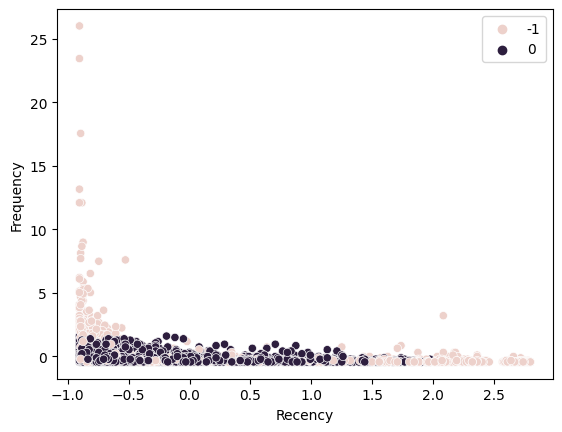

In [870]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

## So, we again get optimal number of clusters as 3

## Case 2: Applying PCA

In [871]:
pca=PCA(n_components=0.99)
pca.fit(df)
pca_transformed_df=pca.transform(df)

In [872]:
nbrs=NearestNeighbors(n_neighbors=10,algorithm='ball_tree').fit(pca_transformed_df)
distances,indices=nbrs.kneighbors(pca_transformed_df)
k_distance=distances[:,-1]
k_distance_sorted=np.sort(k_distance)

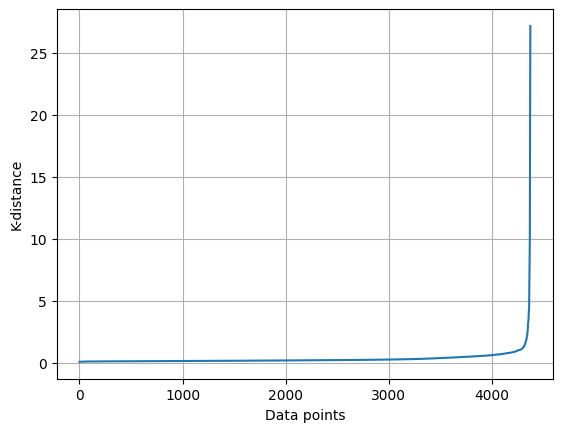

In [873]:
#plotting the k-distance graph to get optimal value of eps
plt.plot(k_distance_sorted)
plt.xlabel('Data points')
plt.ylabel('K-distance')
plt.grid()
plt.show()

### So again optimal eps=1 only

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


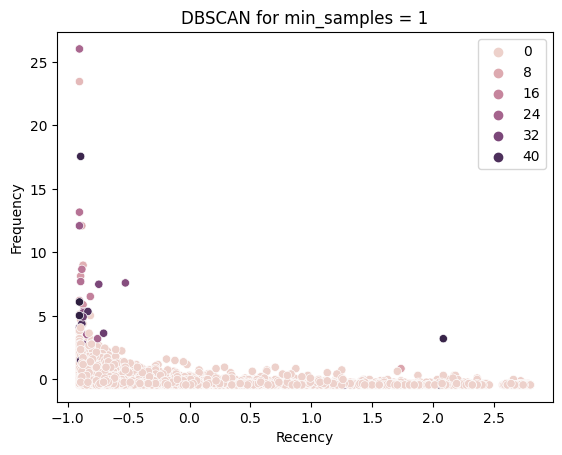

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


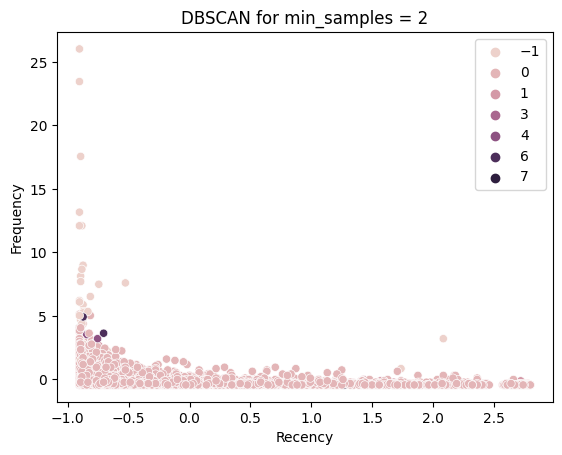

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


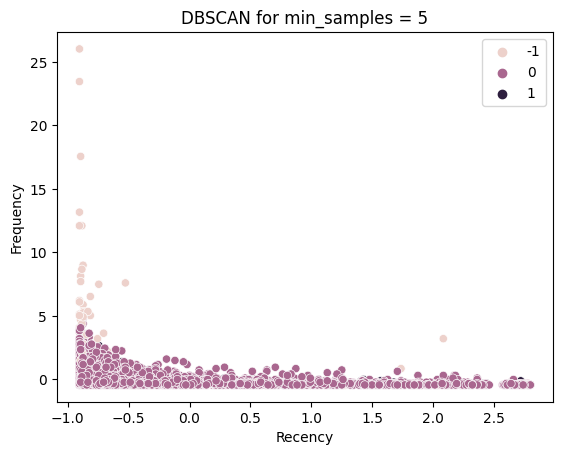

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


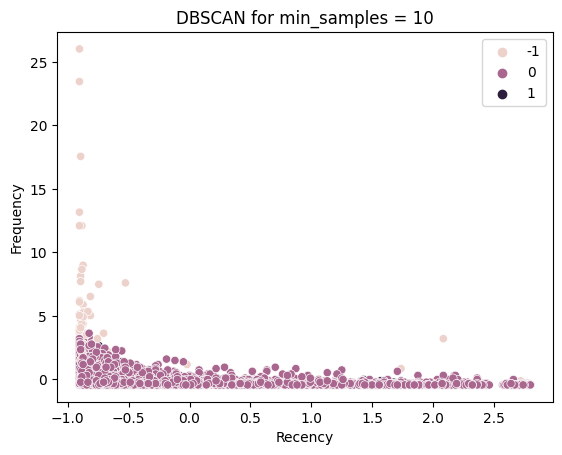

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


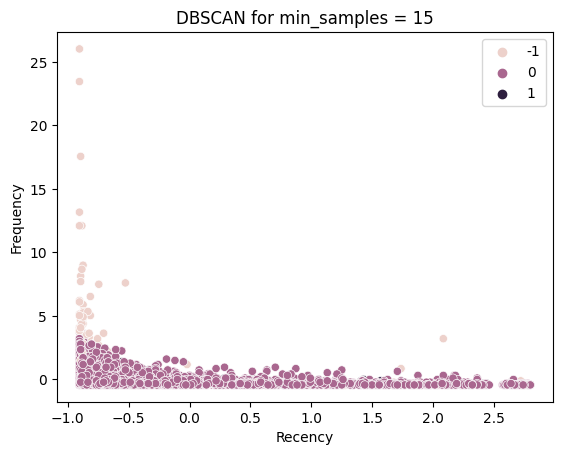

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


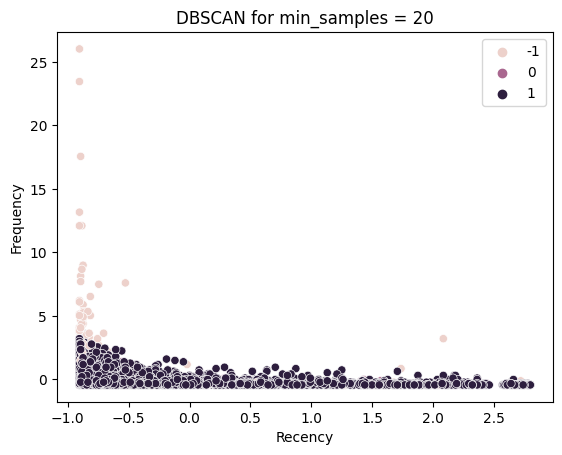

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


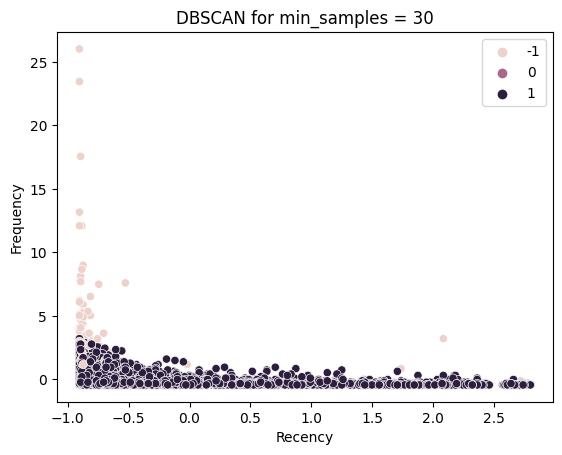

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


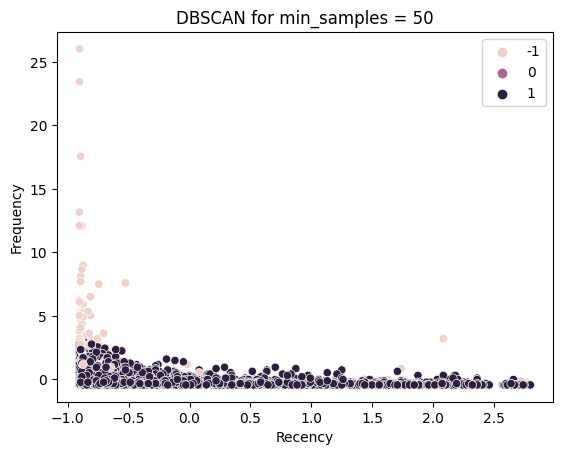

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


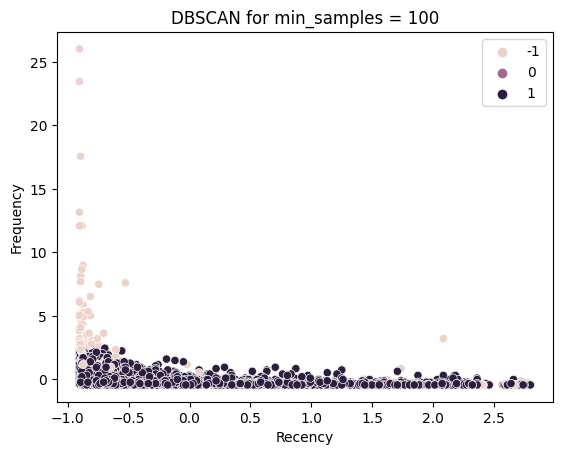

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


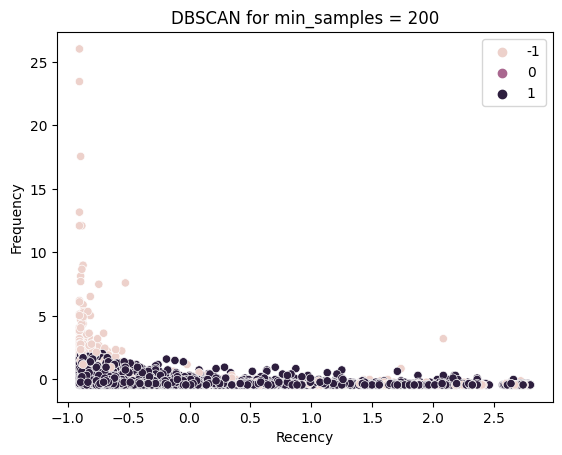

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


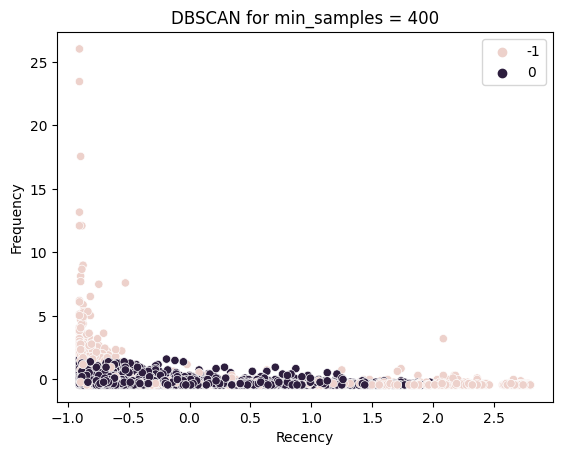

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


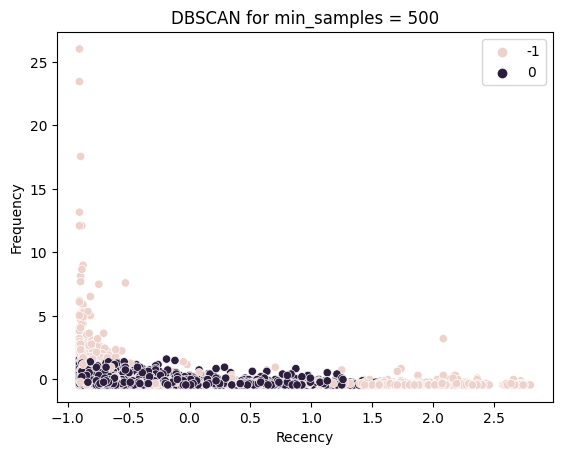

In [874]:
possible_min_samples=[1,2,5,10,15,20,30,50,100,200,400,500]
silhouette_scores=[]
for min_samples in possible_min_samples:
    dbscan2=DBSCAN(eps=1,min_samples=min_samples)
    transformed_df=dbscan2.fit(pca_transformed_df)
    labels=dbscan2.labels_
    silhouette_scores.append(silhouette_score(pca_transformed_df,labels))
    sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
    plt.title(f'DBSCAN for min_samples = {min_samples}')
    plt.show()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Silhouette Score')

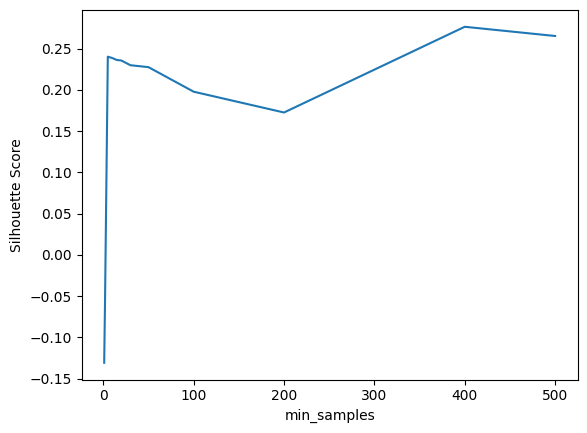

In [875]:
sns.lineplot(possible_min_samples,silhouette_scores)
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')

## We again observe optimal min_samples as 400

In [876]:
dbscan2=DBSCAN(eps=1,min_samples=400)
dbscan2.fit(pca_transformed_df)
labels=dbscan1.labels_
silhouette_score_dictionary['DBSCAN_PCA']=max(silhouette_scores)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

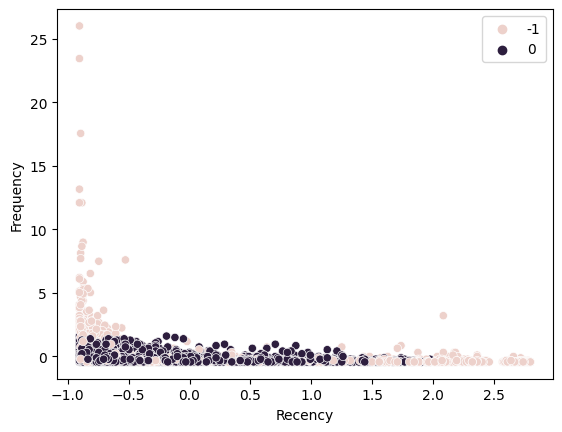

In [877]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

## So, we get optimal number of clusters as 2

## Case 3: Applying ICA

In [878]:
ica=FastICA(n_components=7)
ica.fit(df)
ica_transformed_df=ica.transform(df)

In [879]:
nbrs=NearestNeighbors(n_neighbors=10,algorithm='ball_tree').fit(ica_transformed_df)
distances,indices=nbrs.kneighbors(ica_transformed_df)
k_distance=distances[:,-1]
k_distance_sorted=np.sort(k_distance)

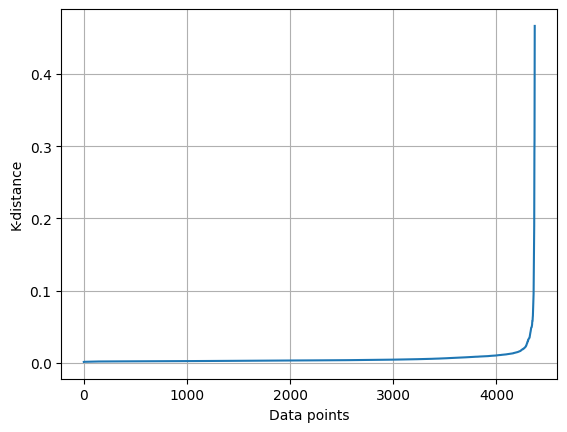

In [880]:
#plotting the k-distance graph to get optimal value of eps
plt.plot(k_distance_sorted)
plt.xlabel('Data points')
plt.ylabel('K-distance')
plt.grid()
plt.show()

### So, we have eps=0.02 as optimal eps

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


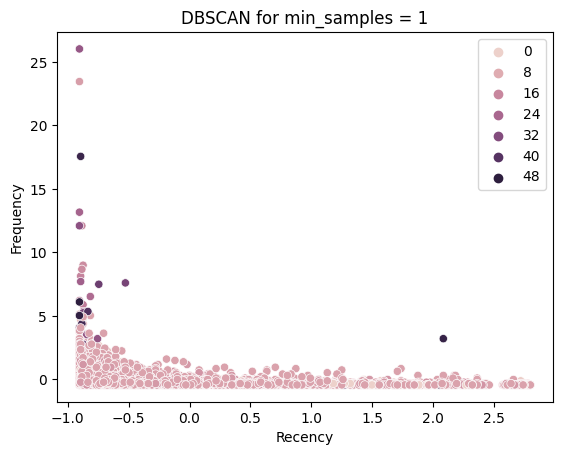

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


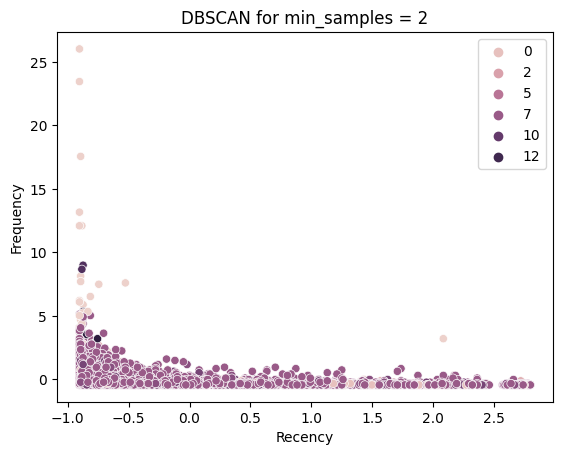

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


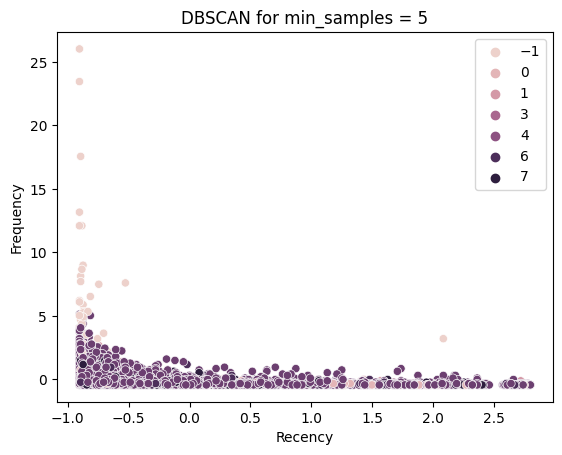

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


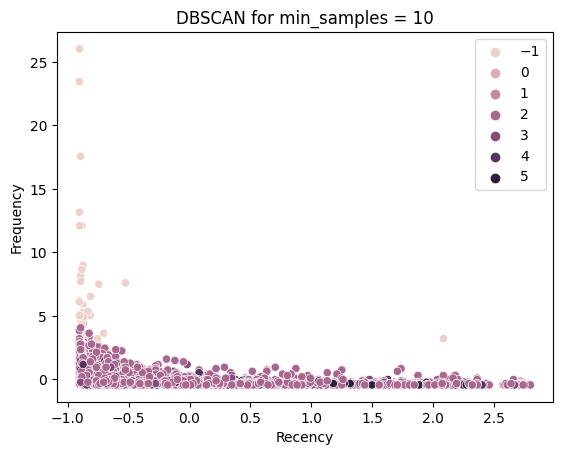

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


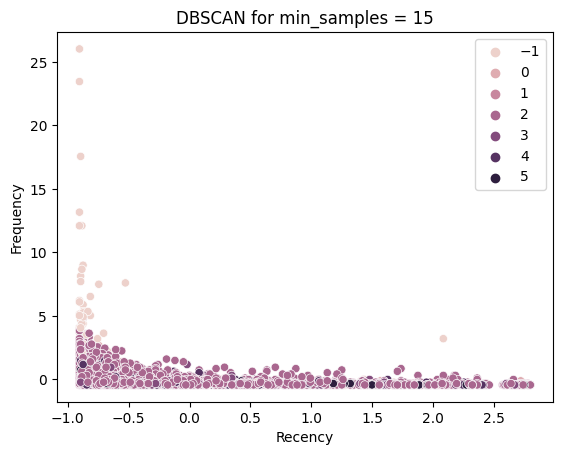

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


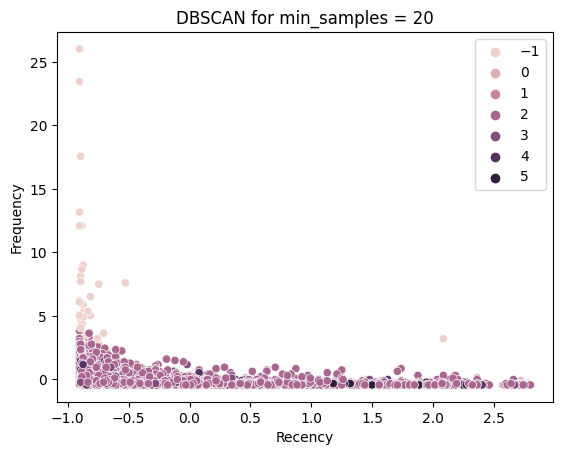

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


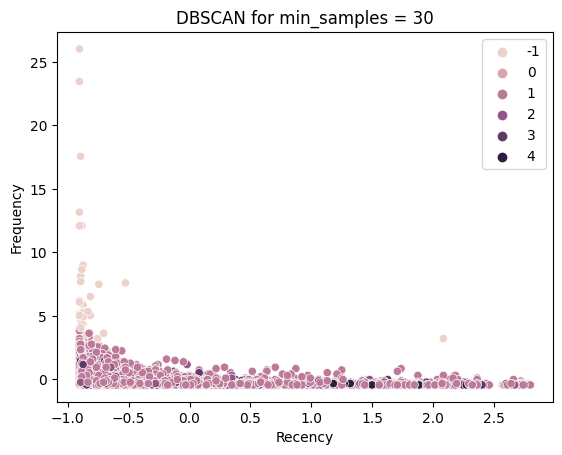

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


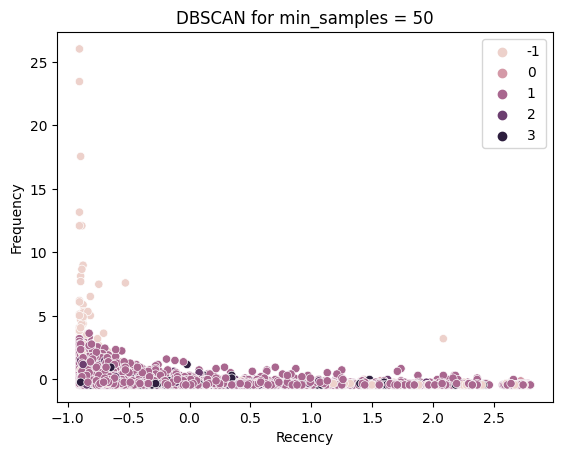

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


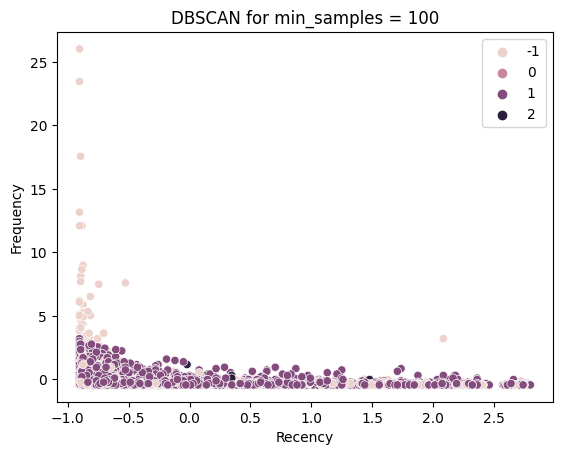

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


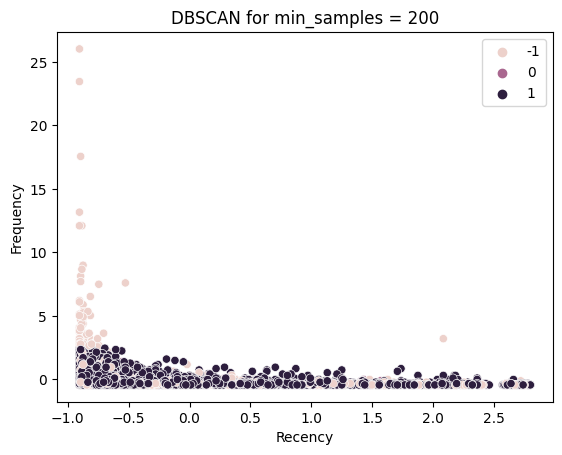

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


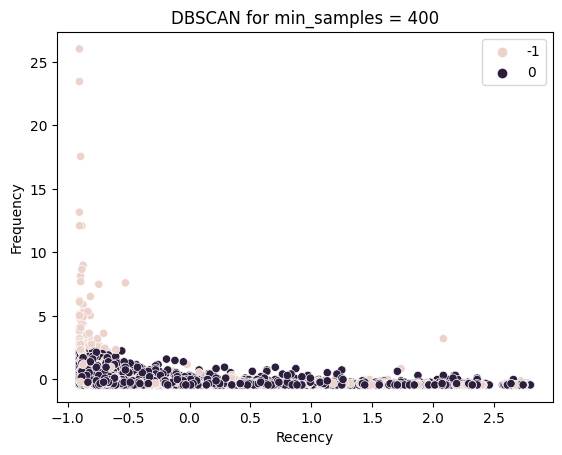

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


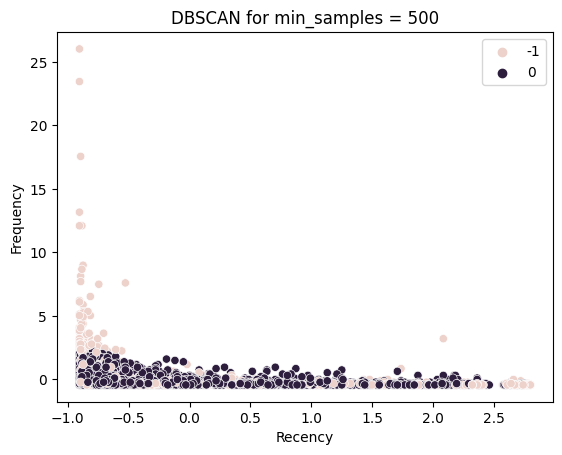

In [881]:
possible_min_samples=[1,2,5,10,15,20,30,50,100,200,400,500]
silhouette_scores=[]
for min_samples in possible_min_samples:
    dbscan3=DBSCAN(eps=0.02,min_samples=min_samples)
    transformed_df=dbscan3.fit(ica_transformed_df)
    labels=dbscan3.labels_
    silhouette_scores.append(silhouette_score(ica_transformed_df,labels))
    sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
    plt.title(f'DBSCAN for min_samples = {min_samples}')
    plt.show()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Silhouette Score')

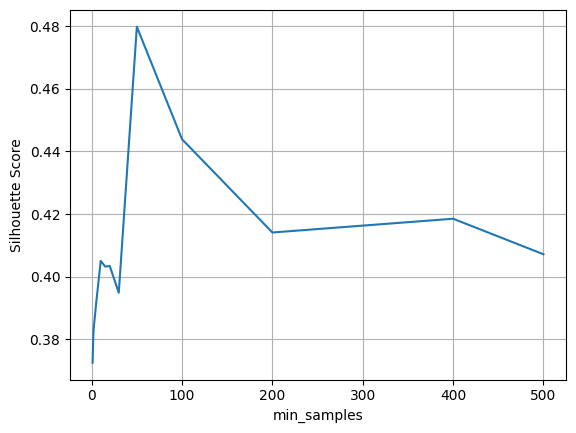

In [882]:
sns.lineplot(possible_min_samples,silhouette_scores)
plt.grid()
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')

### So for min_samples=50 we have best silhouette score

In [883]:
dbscan3=DBSCAN(eps=0.02,min_samples=50)
dbscan3.fit(ica_transformed_df)
labels=dbscan3.labels_
silhouette_score_dictionary['DBSCAN_ICA']=max(silhouette_scores)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

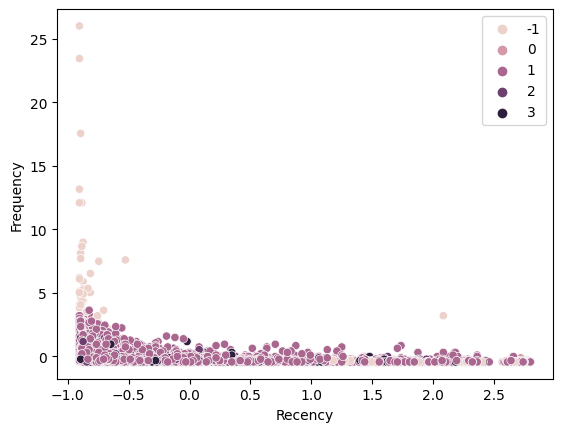

In [884]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

### So, we obtain 5 clusters in this case with one as outlier

In [885]:
outlier_df=df.copy()

### Before Applying KMeans as it is sensitive to outliers to we remove the outliers

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


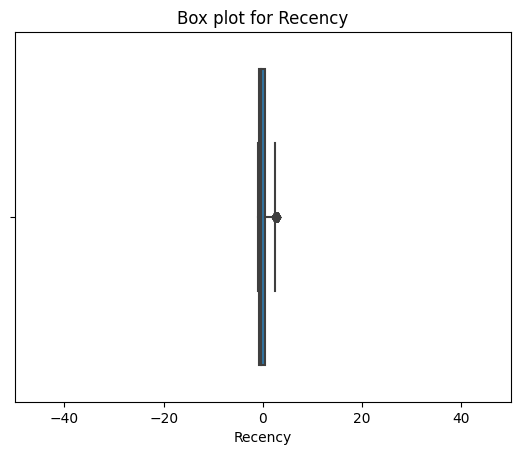

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


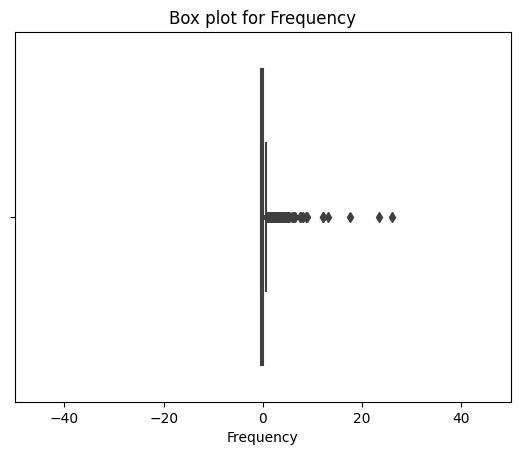

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


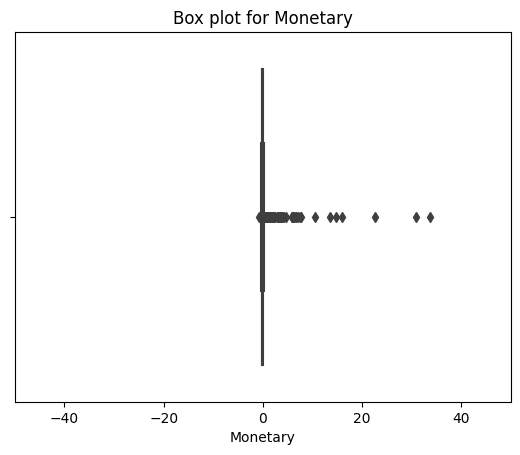

In [886]:
columns=['Recency','Frequency','Monetary']
for column in columns:
    sns.boxplot(df[column])
    plt.title(f"Box plot for {column}")
    plt.xlim(-50,50)
    plt.show()

### As distribution is skewed so we apply IQR method to cap the outliers

In [887]:
for column in columns:
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5)*IQR
    upper_limit=Q3+(1.5)*IQR
    new_column=[]
    for i in range(len(df)):
        value=df[column][i]
        if(value<lower_limit):
            new_column.append(lower_limit)
        elif(value>upper_limit):
            new_column.append(upper_limit)
        else:
            new_column.append(value)
    df[column]=new_column

# Affinity Propagation

## Case 1: Without Feature Extraction

In [1015]:
ap=AffinityPropagation(random_state=0)
ap.fit(outlier_df)
labels=ap.predict(outlier_df)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

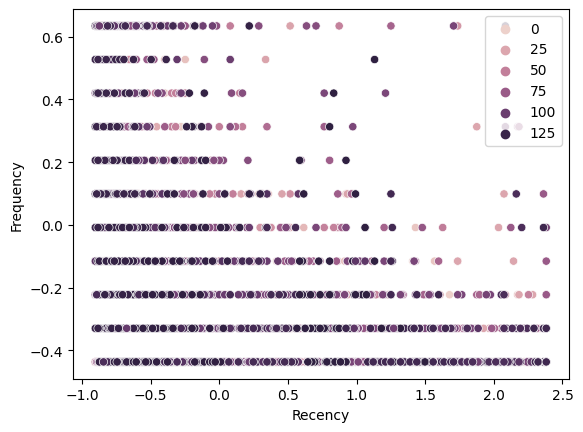

In [1016]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

In [1017]:
silhouette_score_dictionary['AffinityPropagation']=silhouette_score(outlier_df,labels)

## Case 2: Applying PCA

In [1018]:
pca=PCA(n_components=0.99)
pca_transformed_df=pca.fit_transform(outlier_df)

In [1019]:
ap2=AffinityPropagation(random_state=0)
ap2.fit(pca_transformed_df)

AffinityPropagation(random_state=0)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

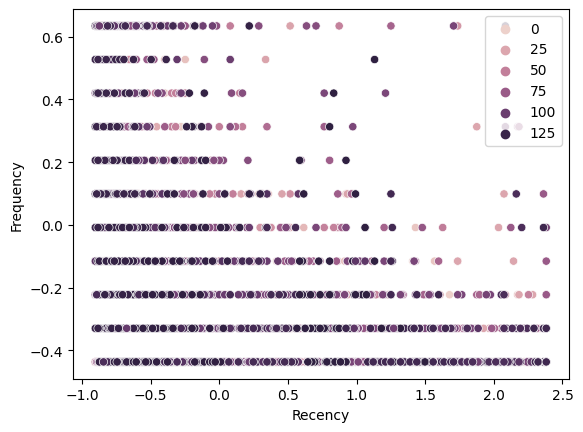

In [1020]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

In [1021]:
labels=ap2.predict(pca_transformed_df)
silhouette_score_dictionary['AffinityPropagation_PCA']=silhouette_score(outlier_df,labels)

## Case 3: Applying ICA

In [1022]:
ica=FastICA(n_components=7)
ica_transformed_df=ica.fit_transform(outlier_df)

In [1023]:
ap3=AffinityPropagation(random_state=0)
ap3.fit(ica_transformed_df)

AffinityPropagation(random_state=0)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


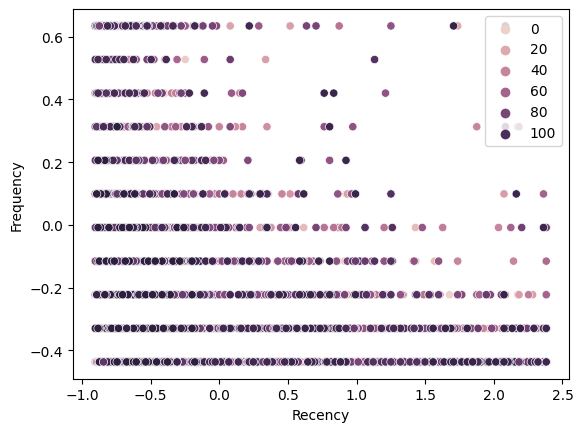

In [1024]:
labels=ap3.predict(ica_transformed_df)
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
silhouette_score_dictionary['AffinityPropagation_ICA']=silhouette_score(outlier_df,labels)

# KMeans

## Case 1: Without Feature Extraction

In [896]:
possible_n_clusters=np.arange(2,20)
silhouette_scores=[]
for n_clusters in possible_n_clusters:
    kmeans1=KMeans(n_clusters=n_clusters,init='k-means++',random_state=0)
    predicted=kmeans1.fit_predict(df)
    sil_score=silhouette_score(df,predicted)
    silhouette_scores.append(sil_score)

In [897]:
silhouette_score_dictionary['KMeans']=max(silhouette_scores)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


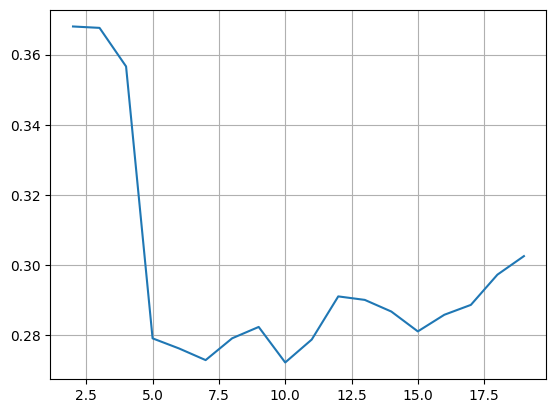

In [898]:
sns.lineplot(possible_n_clusters,silhouette_scores)
plt.grid()

### So, for n_clusters= 2 we get approximately the best silhouette score

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


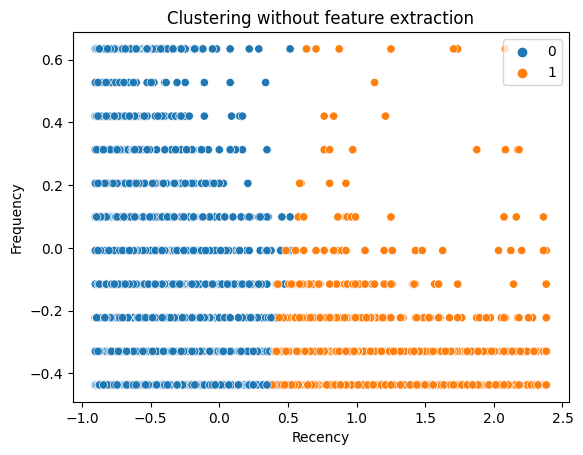

In [899]:
kmeans1=KMeans(n_clusters=2,init='k-means++',random_state=0)
kmeans1.fit(df)
labels=kmeans1.labels_
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
plt.title('Clustering without feature extraction')
plt.show()

## Case 2: Applying PCA

In [900]:
pca=PCA(n_components=0.99)

In [901]:
pca.fit(df)
pca_transformed_df=pca.transform(df)

In [902]:
possible_n_clusters=np.arange(2,20)
silhouette_scores=[]
for n_clusters in possible_n_clusters:
    kmeans1=KMeans(n_clusters=n_clusters,init='k-means++',random_state=0)
    predicted=kmeans1.fit_predict(pca_transformed_df)
    sil_score=silhouette_score(pca_transformed_df,predicted)
    silhouette_scores.append(sil_score)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


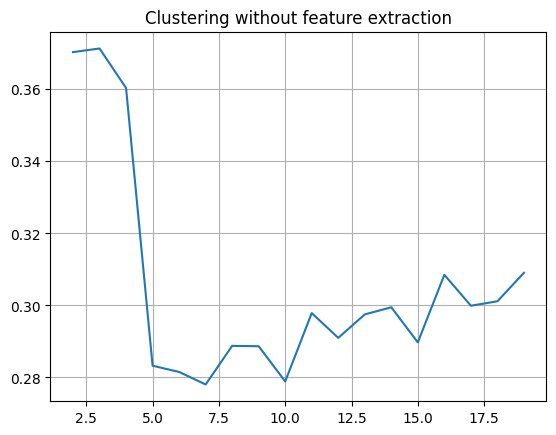

In [903]:
sns.lineplot(possible_n_clusters,silhouette_scores)
plt.title('Clustering without feature extraction')
plt.grid()
plt.show()

### Again, we can see that n_clusters=3 gives the best silhouette score

In [904]:
silhouette_score_dictionary['KMeans_PCA']=max(silhouette_scores)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


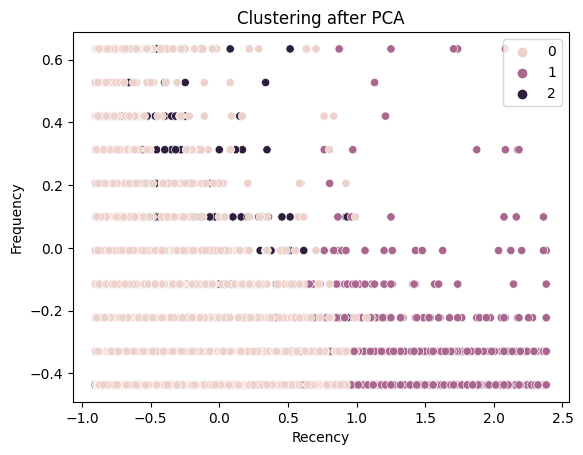

In [905]:
kmeans2=KMeans(n_clusters=3,init='k-means++',random_state=0)
kmeans2.fit(pca_transformed_df)
labels=kmeans2.labels_
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
plt.title('Clustering after PCA')
plt.show()

## Case 3: Applying ICA

In [906]:
ica=FastICA(n_components=7)
ica_transformed_df=ica.fit_transform(df)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [907]:
possible_n_clusters=np.arange(2,20)
silhouette_scores=[]
for n_clusters in possible_n_clusters:
    kmeans1=KMeans(n_clusters=n_clusters,init='k-means++',random_state=0)
    predicted=kmeans1.fit_predict(ica_transformed_df)
    sil_score=silhouette_score(ica_transformed_df,predicted)
    silhouette_scores.append(sil_score)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


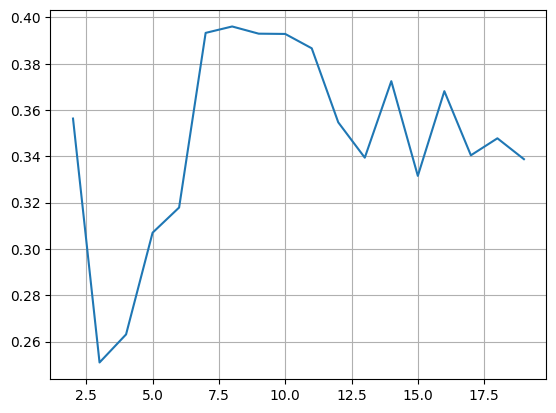

In [908]:
sns.lineplot(possible_n_clusters,silhouette_scores)
plt.grid()

### So, with ICA n_clusters=4 gives the best silhouette score

In [909]:
silhouette_score_dictionary['KMeans_ICA']=max(silhouette_scores)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


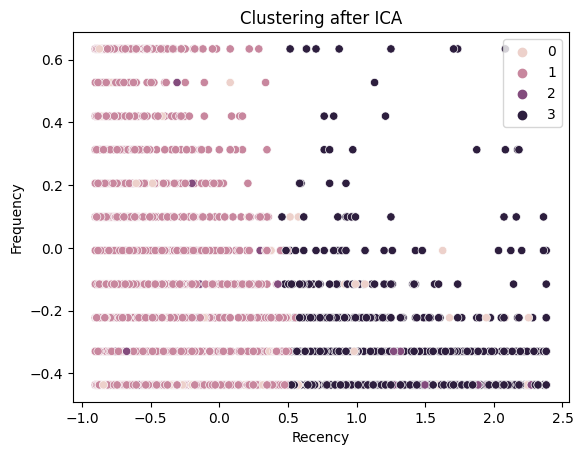

In [910]:
kmeans3=KMeans(n_clusters=4,init='k-means++',random_state=0)
kmeans3.fit(ica_transformed_df)
labels=kmeans3.labels_
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
plt.title('Clustering after ICA')
plt.show()

### So, we get 3 clusters

## Case 4: Applying SVD

In [911]:
svd=TruncatedSVD(n_components=7)
svd_transformed_df=ica.fit_transform(df)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [912]:
possible_n_clusters=np.arange(2,20)
silhouette_scores=[]
for n_clusters in possible_n_clusters:
    kmeans1=KMeans(n_clusters=n_clusters,init='k-means++',random_state=0)
    predicted=kmeans1.fit_predict(svd_transformed_df)
    sil_score=silhouette_score(svd_transformed_df,predicted)
    silhouette_scores.append(sil_score)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


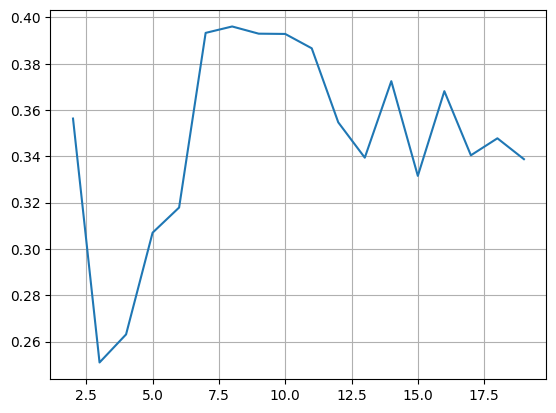

In [913]:
sns.lineplot(possible_n_clusters,silhouette_scores)
plt.grid()

### So, with SVD n_clusters=4 gives the best silhouette score

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


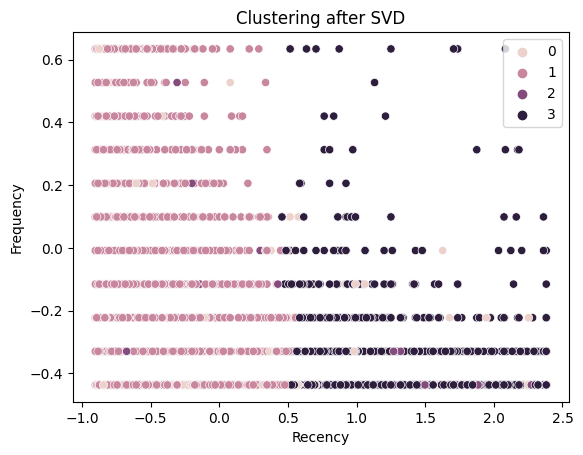

In [914]:
kmeans4=KMeans(n_clusters=4,init='k-means++',random_state=0)
kmeans4.fit(svd_transformed_df)
labels=kmeans3.labels_
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)
plt.title('Clustering after SVD')
plt.show()

In [915]:
silhouette_score_dictionary['KMeans_SVD']=max(silhouette_scores)

# Hierarchical Clustering

## Case 1:Without Feature Extraction

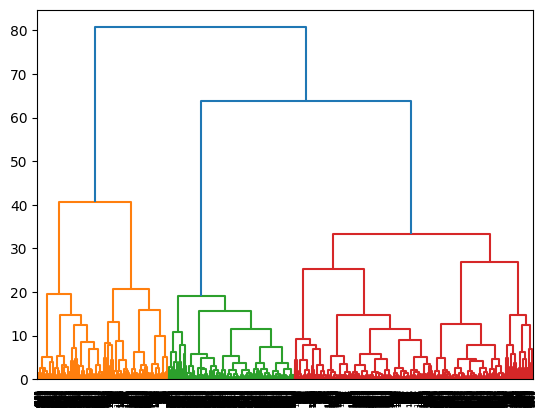

In [916]:
dendrogram=sch.dendrogram(sch.linkage(df,method='ward'))

### So, largest vertical line we can make without cutting any horizontal line shows that we can get n_clusters=2 as it would be cutting the blue lines

In [917]:
hierarchical=AgglomerativeClustering(n_clusters=2,linkage ='ward',affinity = 'euclidean')
labels=hierarchical.fit_predict(df)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

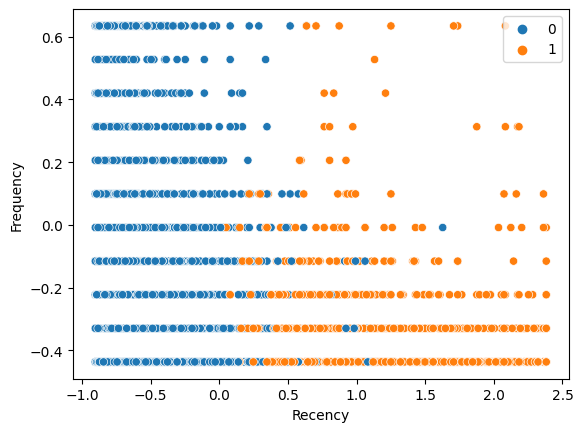

In [918]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

In [919]:
silhouette_score_dictionary['Hierarchical']=silhouette_score(df,labels)

## Case 2:With PCA

In [920]:
pca=PCA(n_components=0.99)

In [921]:
pca.fit(df)
pca_transformed_df=pca.transform(df)

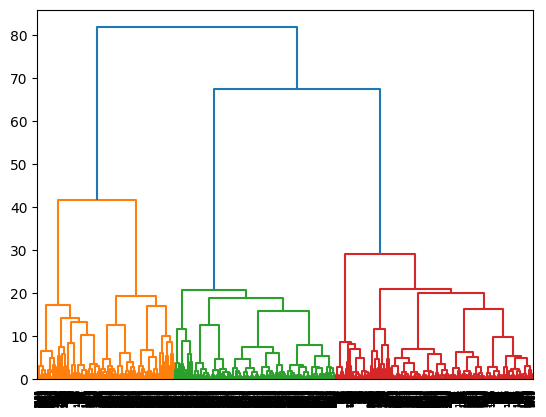

In [922]:
dendrogram=sch.dendrogram(sch.linkage(pca_transformed_df,method='ward'))

### Again we have optimal n_clusters as 2

In [923]:
hierarchical2=AgglomerativeClustering(n_clusters=2,linkage ='ward',affinity = 'euclidean')
labels=hierarchical2.fit_predict(pca_transformed_df)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

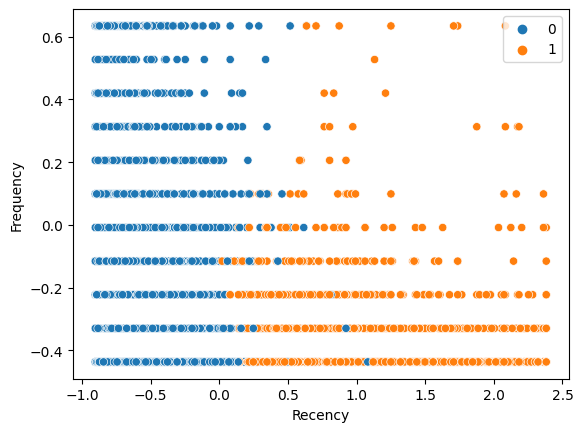

In [924]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

In [925]:
silhouette_score_dictionary['Hierarchical_PCA']=silhouette_score(pca_transformed_df,labels)

## Case 3: Applying ICA

In [926]:
ica=FastICA(n_components=7)
ica_transformed_df=ica.fit_transform(df)

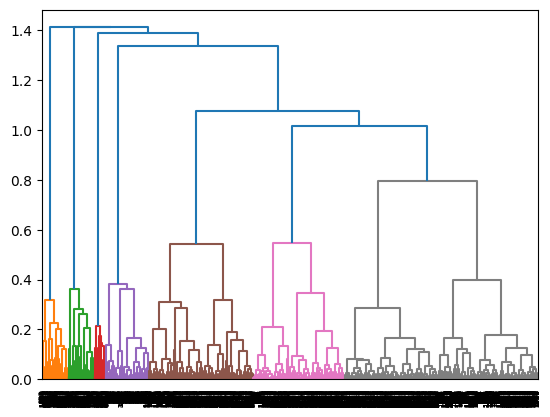

In [927]:
dendrogram=sch.dendrogram(sch.linkage(ica_transformed_df,method='ward'))

### Using the above concept we get optimal number of clusters as 5

In [928]:
hierarchical3=AgglomerativeClustering(n_clusters=5,linkage ='ward',affinity = 'euclidean')
labels=hierarchical3.fit_predict(ica_transformed_df)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

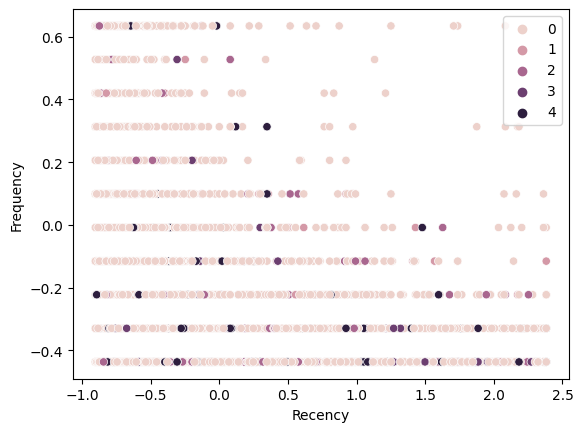

In [929]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

In [930]:
silhouette_score_dictionary['Hierarchical_ICA']=silhouette_score(ica_transformed_df,labels)

# Case 4: Applying SVD

In [931]:
svd=TruncatedSVD(n_components=3)
svd_transformed_df=svd.fit_transform(df)

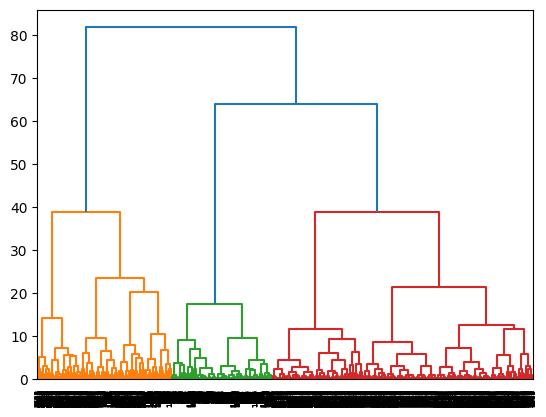

In [932]:
dendrogram=sch.dendrogram(sch.linkage(svd_transformed_df,method='ward'))

In [933]:
hierarchical3=AgglomerativeClustering(n_clusters=2,linkage ='ward',affinity = 'euclidean')
labels=hierarchical3.fit_predict(ica_transformed_df)

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Recency', ylabel='Frequency'>

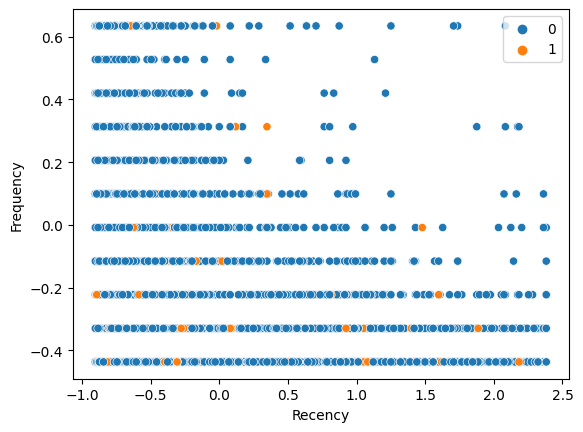

In [934]:
sns.scatterplot(df['Recency'],df['Frequency'],hue=labels)

In [935]:
silhouette_score_dictionary['Hierarchical_SVD']=silhouette_score(svd_transformed_df,labels)

# Spectral Clustering

## Case 1: Without feature extraction

In [936]:
silhouette_scores=[]
for n_components in range(1,len(df.columns)+1,1):
    spectral=SpectralClustering(n_components=n_components)
    spectral.fit(df)
    labels=spectral.labels_
    silhouette_scores.append(silhouette_score(df,labels))

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


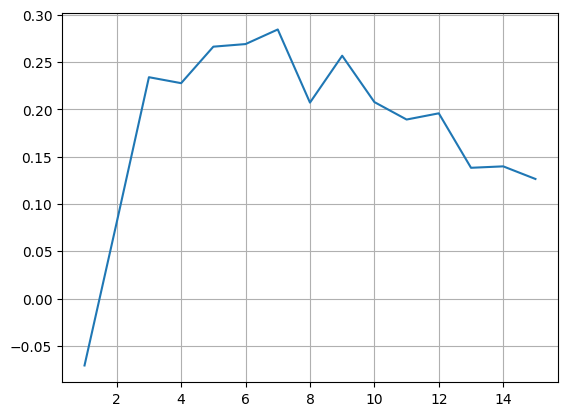

In [937]:
sns.lineplot(list(range(1,len(df.columns)+1,1)),silhouette_scores)
plt.grid()

## So, best n_component come out to be 7

In [938]:
spectral1=SpectralClustering(n_components=7)
spectral1.fit(df)
labels=spectral.labels_
silhouette_score_dictionary['Spectral']=silhouette_score(df,labels)

## Case 2: Applying PCA

In [939]:
pca=PCA(n_components=0.99)
pca_transformed_df=pca.fit_transform(df)

In [940]:
silhouette_scores=[]
for n_components in range(1,len(pca_transformed_df[0])+1,1):
    spectral=SpectralClustering(n_components=n_components)
    spectral.fit(pca_transformed_df)
    labels=spectral.labels_
    silhouette_scores.append(silhouette_score(pca_transformed_df,labels))

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


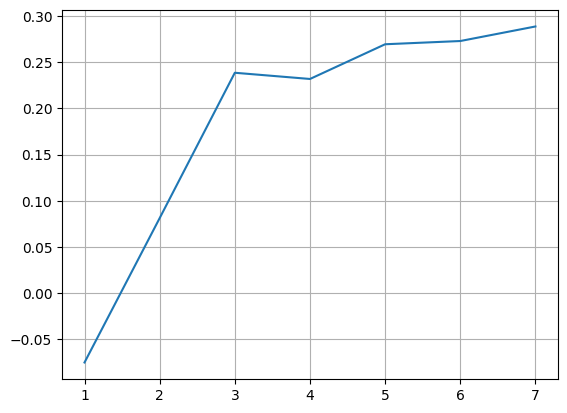

In [941]:
sns.lineplot(list(range(1,len(pca_transformed_df[0])+1,1)),silhouette_scores)
plt.grid()

In [942]:
spectral2=SpectralClustering(n_components=7)
spectral2.fit(pca_transformed_df)
labels=spectral.labels_
silhouette_score_dictionary['Spectral_PCA']=silhouette_score(pca_transformed_df,labels)

## Case 3: Applying ICA

In [943]:
ica=PCA(n_components=10)
ica_transformed_df=pca.fit_transform(df)

In [944]:
silhouette_scores=[]
for n_components in range(1,len(ica_transformed_df[0])+1,1):
    spectral=SpectralClustering(n_components=n_components)
    spectral.fit(ica_transformed_df)
    labels=spectral.labels_
    silhouette_scores.append(silhouette_score(ica_transformed_df,labels))

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


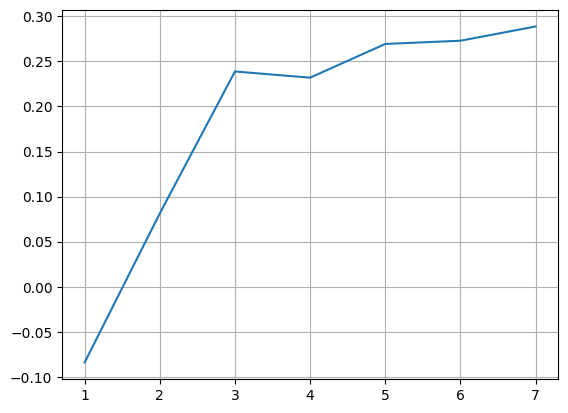

In [945]:
sns.lineplot(list(range(1,len(pca_transformed_df[0])+1,1)),silhouette_scores)
plt.grid()

### So, for n_clusters=2 it gives best silhouette score

In [946]:
spectral3=SpectralClustering(n_components=7)
spectral3.fit(ica_transformed_df)
labels=spectral.labels_
silhouette_score_dictionary['Spectral_ICA']=silhouette_score(ica_transformed_df,labels)

## Case 4: Applying SVD

In [947]:
svd=TruncatedSVD(n_components=10)
svd_transformed_df=svd.fit_transform(df)

In [948]:
silhouette_scores=[]
for n_components in range(1,len(svd_transformed_df[0])+1,1):
    spectral=SpectralClustering(n_components=n_components)
    spectral.fit(svd_transformed_df)
    labels=spectral.labels_
    silhouette_scores.append(silhouette_score(svd_transformed_df,labels))

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


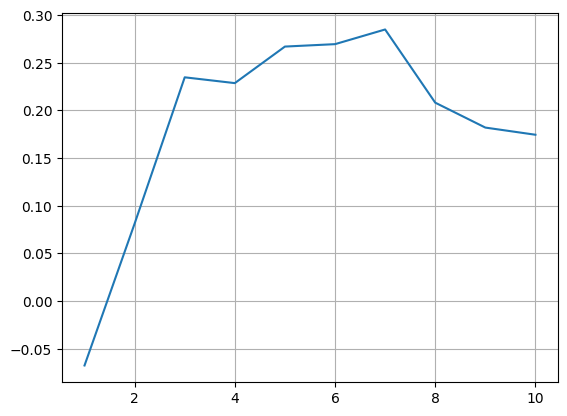

In [949]:
sns.lineplot(list(range(1,len(svd_transformed_df[0])+1,1)),silhouette_scores)
plt.grid()

In [950]:
spectral4=SpectralClustering(n_components=7)
spectral4.fit(svd_transformed_df)
labels=spectral.labels_
silhouette_score_dictionary['Spectral_SVD']=silhouette_score(svd_transformed_df,labels)

In [951]:
print(silhouette_score_dictionary)

{'DBSCAN': 0.2572999362163194, 'DBSCAN_PCA': 0.27649714669442427, 'DBSCAN_ICA': 0.4798828691631323, 'AffinityPropagation': 0.25359205834663273, 'AffinityPropagation_PCA': 0.2557087484799378, 'AffinityPropagation_ICA': 0.23897105559679688, 'KMeans': 0.36800755401490043, 'KMeans_PCA': 0.37133499814923965, 'KMeans_ICA': 0.39606547786111007, 'KMeans_SVD': 0.3960654778611075, 'Hierarchical': 0.348983490105113, 'Hierarchical_PCA': 0.3527956908177343, 'Hierarchical_ICA': 0.46151679186826733, 'Hierarchical_SVD': 0.0883600732711183, 'Spectral': 0.12650070117008894, 'Spectral_PCA': 0.288554828126582, 'Spectral_ICA': 0.28870395876690524, 'Spectral_SVD': 0.1744599156954855}


# So, DBSCAN with ICA gives the best silhouette scores among all the possible combinations we tried

In [952]:
ica=FastICA(n_components=7)
ica.fit(outlier_df)
ica_transformed_df=ica.transform(outlier_df)
best_model=DBSCAN(eps=0.02,min_samples=50)
best_model.fit(ica_transformed_df)
labels=best_model.labels_

In [953]:
unique_labels=set(labels)
final=[]
centroid=[]
for label in unique_labels:
    if(label!=-1):
        final.append(label)
        cluster=outlier_df[labels==label]
        centroid.append(list(np.mean(cluster,axis=0)))


In [954]:
cluster_centre_df=pd.DataFrame(centroid,columns=outlier_df.columns)
cluster_centre_df['Label']=final

In [955]:
print(cluster_centre_df)

   CustomerID  Frequency  Monetary   Recency  Country  \
0   -1.490091  -0.075611  0.016900 -0.002205      0.0   
1    0.162691  -0.053071 -0.069024 -0.039947      1.0   
2    0.133321  -0.071392 -0.067616 -0.098019      1.0   
3    0.088454  -0.285293 -0.165729  0.308750      1.0   

   ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                      0.0                0.0                   0.0   
1                      0.0                0.0                   0.0   
2                      1.0                0.0                   0.0   
3                      0.0                0.0                   0.0   

   ProductType_Electronics  ProductType_Food  ProductType_Home Decor  \
0                      0.0               0.0                     0.0   
1                      0.0               0.0                     0.0   
2                      0.0               0.0                     0.0   
3                      0.0               0.0                     1.0  

In [956]:
new_df=outlier_df.copy()

In [957]:
new_df['Labels']=labels

In [958]:
new_df[['CustomerID','Frequency','Monetary','Recency']]=scaler.inverse_transform(df[['CustomerID','Frequency','Monetary','Recency']])

In [959]:
print(new_df)

      CustomerID  Frequency    Monetary  Recency  Country  \
0        12346.0        2.0     0.00000    326.0        1   
1        12347.0        7.0  3589.26875      2.0        0   
2        12348.0        4.0  1797.24000     75.0        0   
3        12349.0        1.0  1757.55000     19.0        0   
4        12350.0        1.0   334.40000    310.0        0   
...          ...        ...         ...      ...      ...   
4367     18280.0        1.0   180.60000    278.0        1   
4368     18281.0        1.0    80.82000    181.0        1   
4369     18282.0        3.0   176.60000      8.0        1   
4370     18283.0       11.0  2094.88000      4.0        1   
4371     18287.0        3.0  1837.28000     43.0        1   

      ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                           0                  0                     1   
1                           0                  0                     0   
2                           0                

In [960]:
new_customer_id=[]
for i in range(len(cluster_centre_df)):
    new_customer_id.append(cluster_centre_df['CustomerID'][i]*std_cust+mean_cust)
cluster_centre_df['CustomerID']=new_customer_id

In [961]:
new_frequency=[]
for i in range(len(cluster_centre_df)):
    new_frequency.append(cluster_centre_df['Frequency'][i]*std_freq+mean_freq)
cluster_centre_df['Frequency']=new_frequency

In [962]:
new_money=[]
for i in range(len(cluster_centre_df)):
    new_money.append(cluster_centre_df['Monetary'][i]*std_money+mean_money)
cluster_centre_df['Monetary']=new_money

In [963]:
new_recen=[]
for i in range(len(cluster_centre_df)):
    new_recen.append(cluster_centre_df['Recency'][i]*std_recen+mean_recen)
cluster_centre_df['Recency']=new_recen

In [964]:
print(cluster_centre_df)

     CustomerID  Frequency     Monetary     Recency  Country  \
0  12733.159243   4.369364  2037.369137   91.824975      0.0   
1  15579.895388   4.579860  1331.129744   88.021821      1.0   
2  15529.308031   4.408764  1342.700084   82.170141      1.0   
3  15452.030699   2.411200   536.279384  123.158425      1.0   

   ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                      0.0                0.0                   0.0   
1                      0.0                0.0                   0.0   
2                      1.0                0.0                   0.0   
3                      0.0                0.0                   0.0   

   ProductType_Electronics  ProductType_Food  ProductType_Home Decor  \
0                      0.0               0.0                     0.0   
1                      0.0               0.0                     0.0   
2                      0.0               0.0                     0.0   
3                      0.0         

In [965]:
columns_ohe=[
    'ProductType_Accessories',
    'ProductType_Books',
    'ProductType_Clothing',
    'ProductType_Electronics',
    'ProductType_Food',
    'ProductType_Home Decor',
    'ProductType_Office Supplies',
    'ProductType_Others',
    'ProductType_Pet Supplies',
    'ProductType_Toys'
]

In [966]:
label_outlier_df=new_df[new_df['Labels']==-1]
print(label_outlier_df)

      CustomerID  Frequency  Monetary  Recency  Country  \
0        12346.0        2.0      0.00    326.0        1   
9        12356.0        3.0   2811.43     23.0        0   
23       12373.0        1.0    364.60    311.0        0   
25       12375.0        3.0    455.42      3.0        0   
29       12380.0        5.0   2720.56     22.0        0   
...          ...        ...       ...      ...      ...   
4256     18133.0        2.0    715.50    211.0        1   
4261     18141.0        1.0    -35.40    332.0        1   
4288     18176.0        2.0    448.65    332.0        1   
4321     18220.0        2.0    297.78    220.0        1   
4343     18246.0        2.0    596.10     24.0        1   

      ProductType_Accessories  ProductType_Books  ProductType_Clothing  \
0                           0                  0                     1   
9                           0                  0                     0   
23                          1                  0                     

In [967]:
cluster_centre_df['ProductType']=[
    'Others',
    'Others',
    'Accessories',
    'Home Decor'
]

In [968]:
for column in columns_ohe:
    del cluster_centre_df[column]

In [969]:
print(cluster_centre_df)

     CustomerID  Frequency     Monetary     Recency  Country  Label  \
0  12733.159243   4.369364  2037.369137   91.824975      0.0      0   
1  15579.895388   4.579860  1331.129744   88.021821      1.0      1   
2  15529.308031   4.408764  1342.700084   82.170141      1.0      2   
3  15452.030699   2.411200   536.279384  123.158425      1.0      3   

   ProductType  
0       Others  
1       Others  
2  Accessories  
3   Home Decor  


In [970]:
cluster_centre_df['Country']=['International','Domestic','Domestic','Domestic']
del cluster_centre_df['CustomerID']

In [971]:
cluster_centre_df

Frequency     Monetary     Recency        Country  Label  ProductType
0   4.369364  2037.369137   91.824975  International      0       Others
1   4.579860  1331.129744   88.021821       Domestic      1       Others
2   4.408764  1342.700084   82.170141       Domestic      2  Accessories
3   2.411200   536.279384  123.158425       Domestic      3   Home Decor

In [972]:
cluster_centre_df['Frequency']=[4,5,4,2]
cluster_centre_df

Frequency     Monetary     Recency        Country  Label  ProductType
0          4  2037.369137   91.824975  International      0       Others
1          5  1331.129744   88.021821       Domestic      1       Others
2          4  1342.700084   82.170141       Domestic      2  Accessories
3          2   536.279384  123.158425       Domestic      3   Home Decor

In [973]:
target_names={
    0:"Spends a good amount overall",
    1:"Visits more frequently than others and has spent descent amount of money",
    2:"Prefers buying Accesories and spent a descent amount of money",
    3:"Less frequently visits the shop and prefers buying Home Decoration"
}

In [974]:
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
gb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 10]}
cb_param_grid = {'iterations': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'depth': [3, 5, 10]}
ab_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
svc_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf']}
xgb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 10]}

In [975]:
models = [
    (RandomForestClassifier(), rf_param_grid),
    (GaussianNB(), nb_param_grid),
    (GradientBoostingClassifier(), gb_param_grid),
    (CatBoostClassifier(), cb_param_grid),
    (AdaBoostClassifier(), ab_param_grid),
    (KNeighborsClassifier(), knn_param_grid),
    (SVC(), svc_param_grid),
]

In [976]:
x_train,x_test,y_train,y_test=train_test_split(new_df.iloc[:,:-1],new_df.iloc[:,-1],train_size=0.8,random_state=0)

In [977]:
best_models = []
for model, param_grid in models:
    clf = GridSearchCV(model, param_grid, cv=5)
    clf.fit(x_train, y_train)
    print(f"Best parameters for {type(model).__name__}: {clf.best_params_}")
    best_models.append(clf.best_estimator_)

Best parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 50}
Best parameters for GaussianNB: {'var_smoothing': 1e-09}
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
0:	learn: 1.5751964	total: 2.24ms	remaining: 110ms
1:	learn: 1.5408827	total: 3.92ms	remaining: 94.2ms
2:	learn: 1.5102356	total: 5.64ms	remaining: 88.4ms
3:	learn: 1.4809194	total: 7.4ms	remaining: 85.1ms
4:	learn: 1.4528725	total: 9.3ms	remaining: 83.7ms
5:	learn: 1.4238097	total: 11.2ms	remaining: 82.1ms
6:	learn: 1.3978152	total: 13ms	remaining: 80ms
7:	learn: 1.3716634	total: 14.7ms	remaining: 77.1ms
8:	learn: 1.3457116	total: 16.7ms	remaining: 76ms
9:	learn: 1.3223881	total: 18.3ms	remaining: 73.3ms
10:	learn: 1.2999847	total: 20ms	remaining: 70.7ms
11:	learn: 1.2782343	total: 21.5ms	remaining: 68.1ms
12:	learn: 1.2555540	total: 23.1ms	remaining: 65.7ms
13:	learn: 1.2347796	total: 24.8ms	remaining: 63.7ms
14:	learn: 1.2136779	total: 2

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

Best parameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'uniform'}
Best parameters for SVC: {'C': 1, 'kernel': 'linear'}


In [978]:
best_acc = 0
best_model = None
for model in best_models:
    acc = model.score(x_test, y_test)
    print(f"Accuracy for {type(model).__name__}: {acc}")
    if acc > best_acc:
        best_acc = acc
        best_model = model

Accuracy for RandomForestClassifier: 0.976
Accuracy for GaussianNB: 0.9771428571428571
Accuracy for GradientBoostingClassifier: 0.9817142857142858
Accuracy for CatBoostClassifier: 0.9851428571428571
Accuracy for AdaBoostClassifier: 0.976
Accuracy for KNeighborsClassifier: 0.8388571428571429
Accuracy for SVC: 0.9154285714285715


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [979]:
print(f"\nBest model: {type(best_model).__name__}, accuracy: {best_acc}")


Best model: CatBoostClassifier, accuracy: 0.9851428571428571


# So, CatBoost gave the Best Acuracy with 'depth': 3, 'iterations': 100, 'learning_rate': 0.1

In [6]:
catboost=CatBoostClassifier(depth=3,iterations=100,learning_rate=0.1)

In [7]:
catboost.fit(x_train,y_train)

0:	learn: 0.6854827	total: 124ms	remaining: 12.3s
1:	learn: 0.6779328	total: 125ms	remaining: 6.11s
2:	learn: 0.6705009	total: 125ms	remaining: 4.04s
3:	learn: 0.6631782	total: 125ms	remaining: 3s
4:	learn: 0.6559709	total: 125ms	remaining: 2.38s
5:	learn: 0.6488702	total: 125ms	remaining: 1.96s
6:	learn: 0.6418773	total: 125ms	remaining: 1.67s
7:	learn: 0.6349906	total: 126ms	remaining: 1.45s
8:	learn: 0.6282111	total: 126ms	remaining: 1.27s
9:	learn: 0.6215321	total: 126ms	remaining: 1.13s
10:	learn: 0.6149541	total: 126ms	remaining: 1.02s
11:	learn: 0.6084809	total: 126ms	remaining: 926ms
12:	learn: 0.6020998	total: 126ms	remaining: 846ms
13:	learn: 0.5958196	total: 127ms	remaining: 777ms
14:	learn: 0.5896326	total: 127ms	remaining: 718ms
15:	learn: 0.5835398	total: 127ms	remaining: 666ms
16:	learn: 0.5775391	total: 127ms	remaining: 620ms
17:	learn: 0.5716280	total: 127ms	remaining: 579ms
18:	learn: 0.5658067	total: 127ms	remaining: 543ms
19:	learn: 0.5600761	total: 127ms	remaining:

In [998]:
Time=input('Enter Time of order : ')

Enter Time of order : 2010-12-01 08:26:00


In [1001]:
Country=input('Enter Country : ')

Enter Country : United Kingdom


In [1002]:
if(Country=='United Kingdom'):
    Country=1
else:
    Country=0

In [1003]:
Product=input('Enter Product you want to buy : ')

Enter Product you want to buy : CREAM CUPID HEARTS COAT HANGER


In [1004]:
Quantity=int(input('Enter Quantity : '))

Enter Quantity : 4


In [1005]:
UnitPrice=4.55

In [1000]:
CustomerID=float(input('Enter CustomerID : '))

Enter CustomerID : 18102.0


In [1006]:
for i in range(len(RFM_df)):
    if(RFM_df['CustomerID'][i]==CustomerID):
        frequency=RFM_df['Frequency'][i]
        recency=0
        monetary=RFM_df['Monetary'][i]+UnitPrice*Quantity
        country=Country
        category=get_product_category(Product)
        customer_id=RFM_df['CustomerID'][i]

In [1007]:
lists=[]
for column in columns_ohe:
    if(column[12:]==category):
        lists.append(1)
    else:
        lists.append(0)

In [1008]:
test_data=np.array([customer_id,frequency,monetary,recency,country]+lists).reshape(1,-1)
test_data=pd.DataFrame(test_data,columns=new_df.columns[:-1])

In [1009]:
def return_monetary(test_data):
    monetary=test_data['Monetary'][0]
    percentile75=new_df['Monetary'].quantile(0.75)
    percentile25=new_df['Monetary'].quantile(0.25)
    IQR=percentile75-percentile25
    lower_limit=percentile25-(1.5)*IQR
    upper_limit=percentile75+(1.5)*IQR
    if(monetary<lower_limit):
        return "Bought a very few Products"
    elif(monetary>lower_limit and monetary<percentile25):
        return "Bought Descent Amount of Products"
    elif(monetary>percentile25 and monetary<percentile75):
        return "Bought Good Amount of Products"
    elif(monetary>percentile75 and monetary<upper_limit):
        return "Bought Many Products"
    elif(monetary>upper_limit):
        return "Buys Products from the Shop very frequently"

In [1010]:
def return_Frequency(test_data):
    Frequency=test_data['Frequency'][0]
    percentile75=new_df['Frequency'].quantile(0.75)
    percentile25=new_df['Frequency'].quantile(0.25)
    IQR=percentile75-percentile25
    lower_limit=percentile25-(1.5)*IQR
    upper_limit=percentile75+(1.5)*IQR
    if(Frequency<lower_limit):
        return "Very Rare Visitor"
    elif(Frequency>lower_limit and Frequency<percentile25):
        return "Visits Few Times"
    elif(Frequency>percentile25 and Frequency<percentile75):
        return "Visits Descent Amount of Times"
    elif(Frequency>percentile75 and Frequency<upper_limit):
        return "Visits Good Amount of Times"
    elif(Frequency>upper_limit):
        return "Very Frequent Customer"

In [1011]:
def return_Recency(test_data):
    Recency=test_data['Recency'][0]
    percentile75=new_df['Recency'].quantile(0.75)
    percentile25=new_df['Recency'].quantile(0.25)
    IQR=percentile75-percentile25
    lower_limit=percentile25-(1.5)*IQR
    upper_limit=percentile75+(1.5)*IQR
    if(Recency<lower_limit):
        return "Visited Very Recently"
    elif(Recency>lower_limit and Recency<percentile25):
        return "Visited Few Days back"
    elif(Recency>percentile25 and Recency<percentile75):
        return "Visited Descent Amount of Days back"
    elif(Recency>percentile75 and Recency<upper_limit):
        return "Visited Good Amount of Days back"
    elif(Recency>upper_limit):
        return "Visited Long Back"

In [1012]:
def return_frequent_product(test_data):
    for i in range(len(product_type_df)):
        if(product_type_df['CustomerID'][i]==test_data['CustomerID'][0]):
            return product_type_df['ProductType'][i]

In [1013]:
predicted_category=catboost.predict(test_data)[0]

In [1014]:
if(CustomerID in list(RFM_df['CustomerID'])):
    if(predicted_category!=-1):
        print(target_names[predicted_category])
    else:
        #treating outliers differently
        print(return_monetary(test_data))
        print(return_Frequency(test_data))
        print(return_Recency(test_data))
        print(f'The user likes buying {return_frequent_product(test_data)} type of product most frequently')
else:
    print('New Customer, No previous data')

Buys Products from the Shop very frequently
Very Frequent Customer
Visited Few Days back
The user likes buying Others type of product most frequently
